In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.optimize import least_squares
import scikit_posthocs as sc

from rdn.dataloading import df_from_tool
from rdn.defaults import default_goda_transformation
from rdn.analysis import multifit_distribution, kruskal_dunn

# Create base dataframe

In [3]:
# Import the data
raw_df = pd.read_pickle('../data/raw_data/raw_goda_data.pkl')

# Apply the cleaning
df = raw_df[raw_df['drug']=='Control']
df = default_goda_transformation(df)

# Take also the sham dataset
sdf = raw_df[raw_df['drug']=='Sham']
sdf = default_goda_transformation(sdf)

t_post_stim = [2,10,20,30,40]

/home/janko/code/phd/rdn-project/src/rdn/defaults/defaultgodatransformation.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['nss'].replace({
/home/janko/code/phd/rdn-project/src/rdn/defaults/defaultgodatransformation.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['nss'].replace({
/h

# Sanity checks

## Basal sizes filtering
We have to verify that the initial conditions are the same for everyone


### Basal RID across nss 

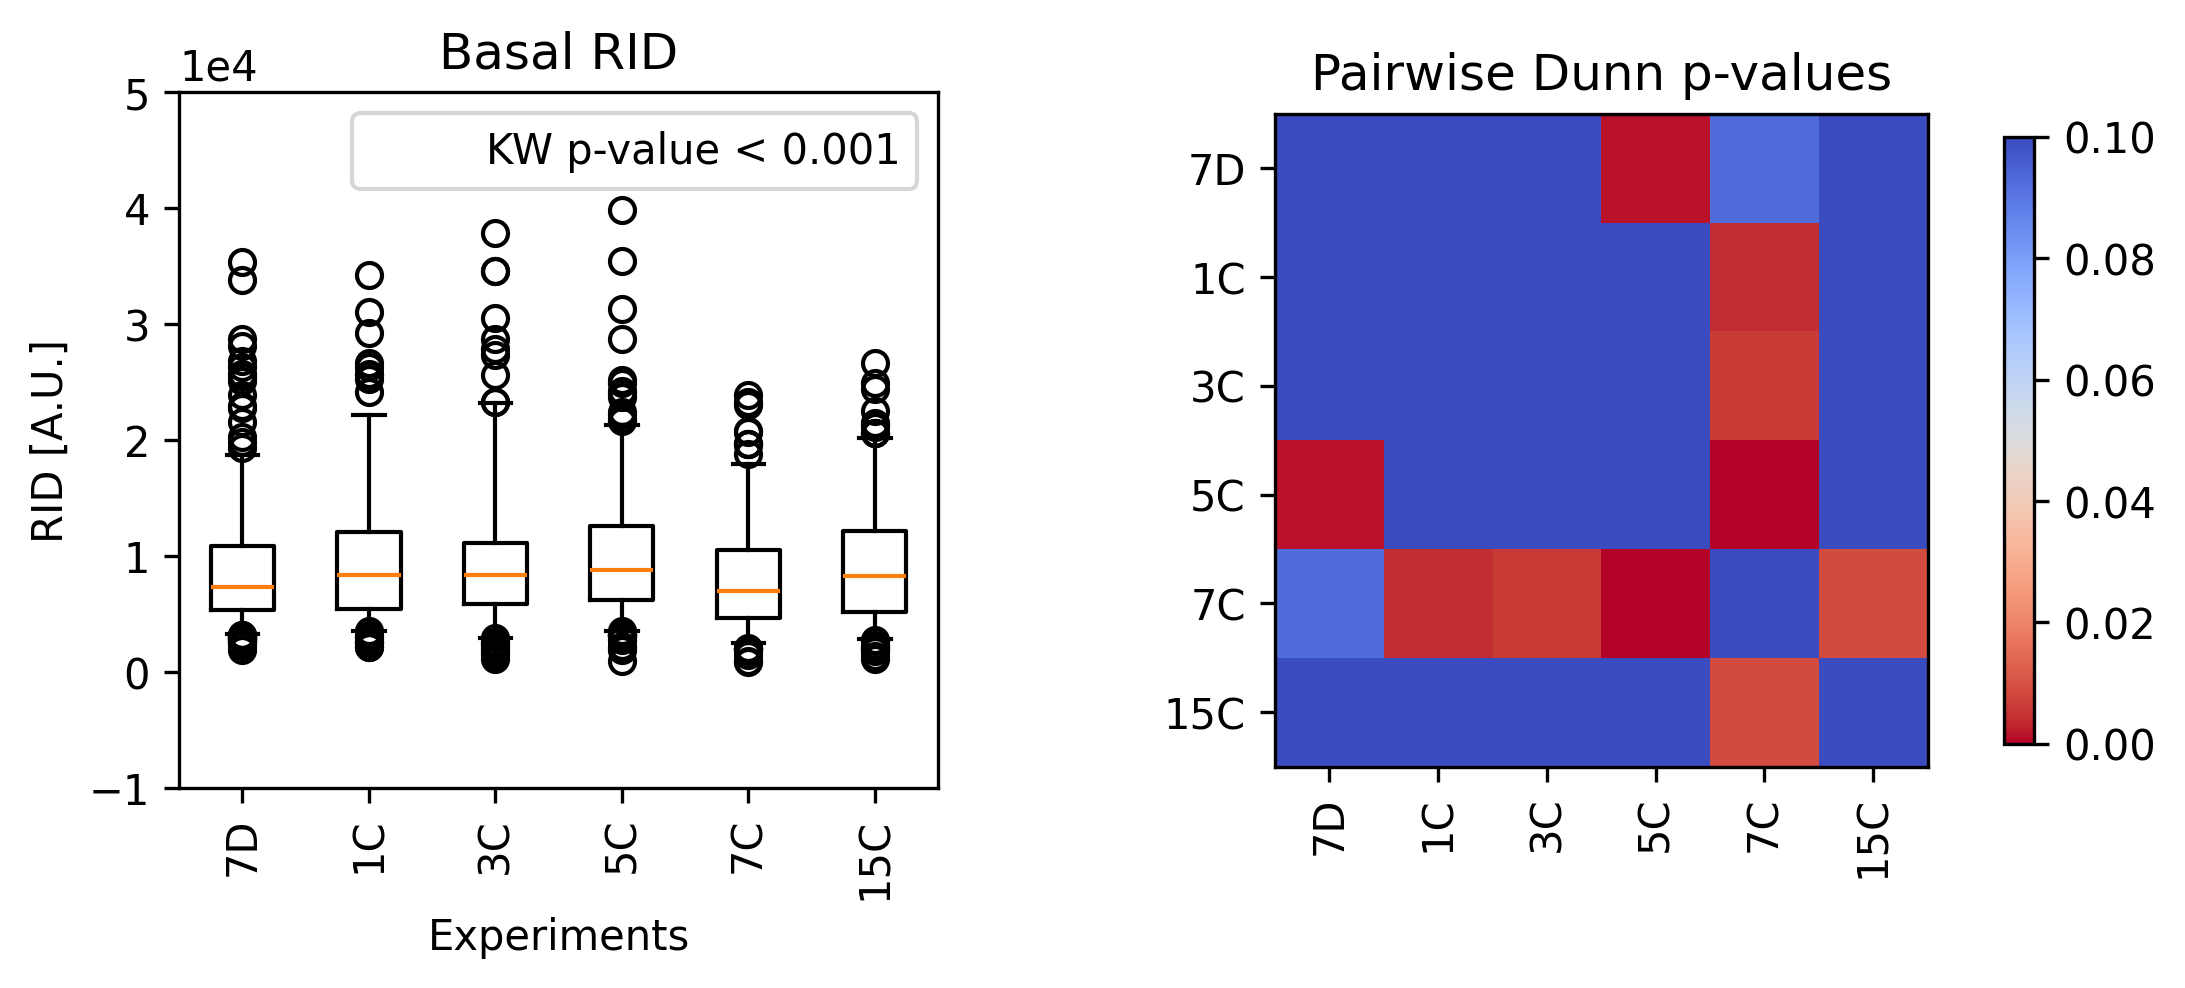

In [4]:
nsss = df['nss'].unique()
nsss_labels = [f'{i}C' for i in nsss[1:]]
nsss_labels.insert(0, '7D')

base_homo_sizes = []
base_hetero_sizes = []
base_sizes = []

for nss in nsss:
    dff = df[df['nss'] == nss]
    base_sizes.append(dff['base_RID'].tolist())
    base_homo_sizes.append(dff[dff['type']=='Stim']['base_RID'].tolist())
    base_hetero_sizes.append(dff[dff['type']=='Spine']['base_RID'].tolist())

# Kruskar-Wallis for all the spine sizes in general
kw,_, axs = kruskal_dunn(base_sizes, nsss_labels, dpi=300, xlabel='Experiments', ylabel='RID [A.U.]');
axs[0].set_title('Basal RID');
axs[0].plot([], [], ' ', label=f'KW p-value < {kw.pvalue:.3f}')
axs[0].set_ylim(-1e4,5e4)
axs[0].legend()


### Basal RID homo vs hetero

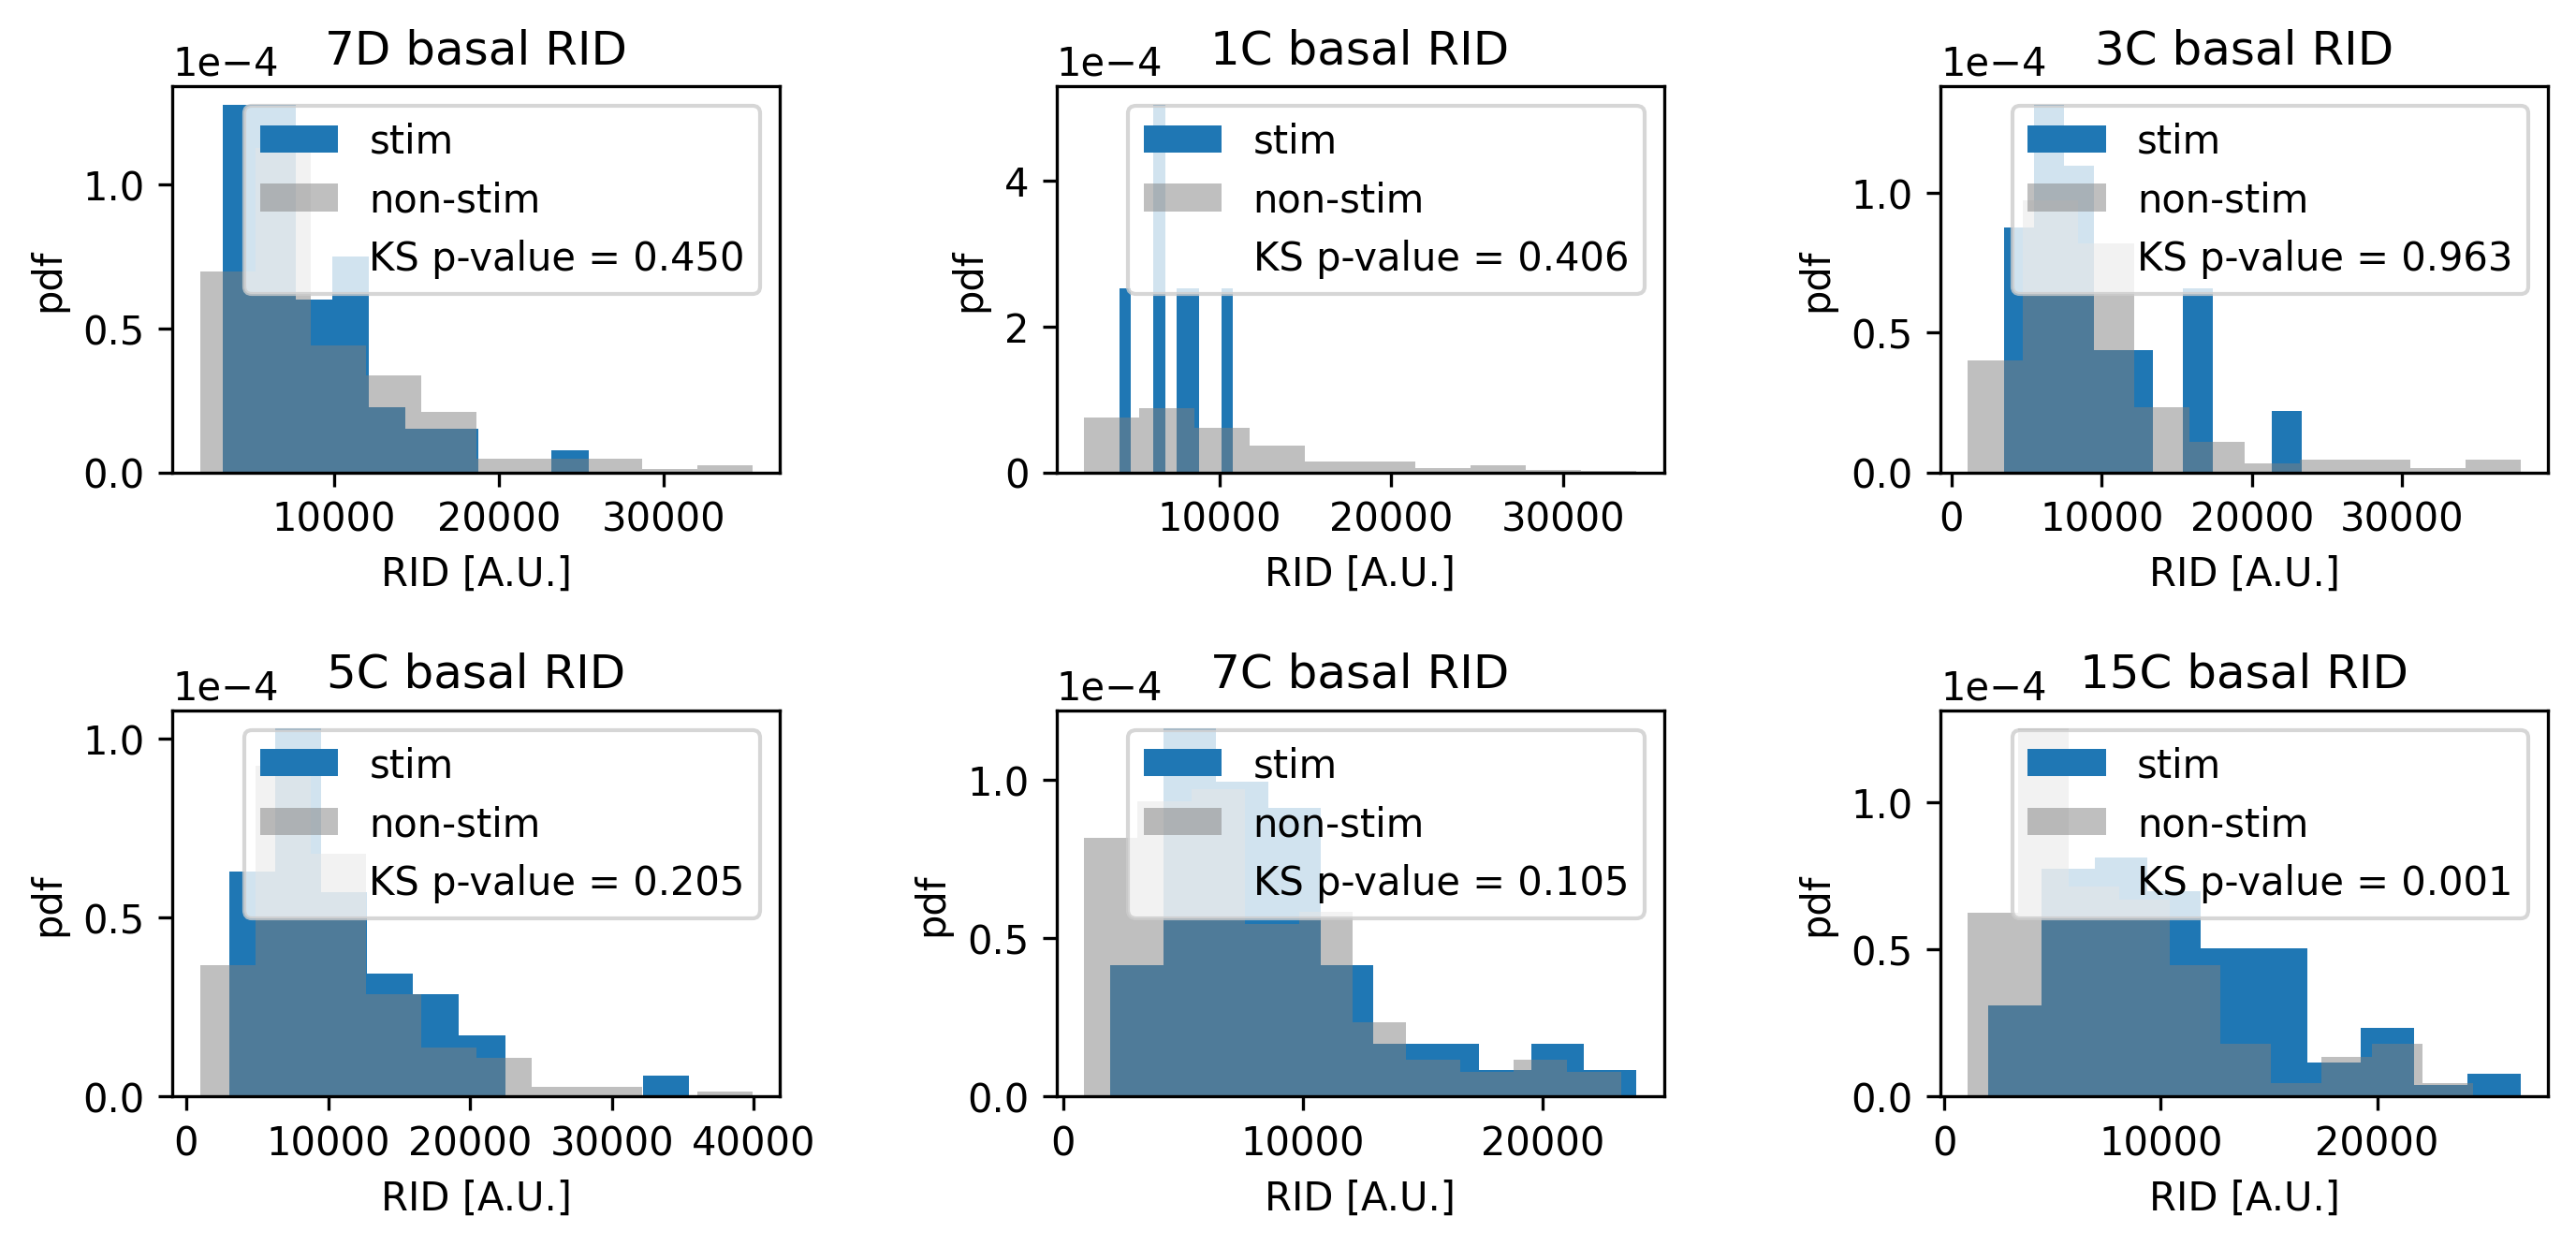

In [5]:
base_homo_sizes = []
base_hetero_sizes = []

for nss in nsss:
    dff = df[df['nss'] == nss]
    base_homo_sizes.append(dff[dff['type']=='Stim']['base_RID'].tolist())
    base_hetero_sizes.append(dff[dff['type']=='Spine']['base_RID'].tolist())


fig, axs = plt.subplots(2,3, dpi=300, figsize=(10,5))
fig.tight_layout(pad=4)


# Test if the homo-ketero pairs come from the same distribution
for ax, homo, hetero, nss in zip(axs.flatten(), base_homo_sizes, base_hetero_sizes, nsss_labels):
    hh_ks = stats.kstest(homo, hetero)
    ax.hist(homo, color='tab:blue', density=True, label='stim');
    ax.hist(hetero, color='gray', histtype='stepfilled', alpha=0.5, density=True, label='non-stim');
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    ax.plot([],[], ' ', label=f'KS p-value = {hh_ks.pvalue:.3f}')

    ax.set_xlabel('RID [A.U.]')
    ax.set_ylabel('pdf')
    ax.set_title(f'{nss} basal RID')

    ax.legend()


### Cell exclusion
Problems:
- 7 Stim is off
- 7 distr vs 5 stim
- 15 stim homo vs hetero

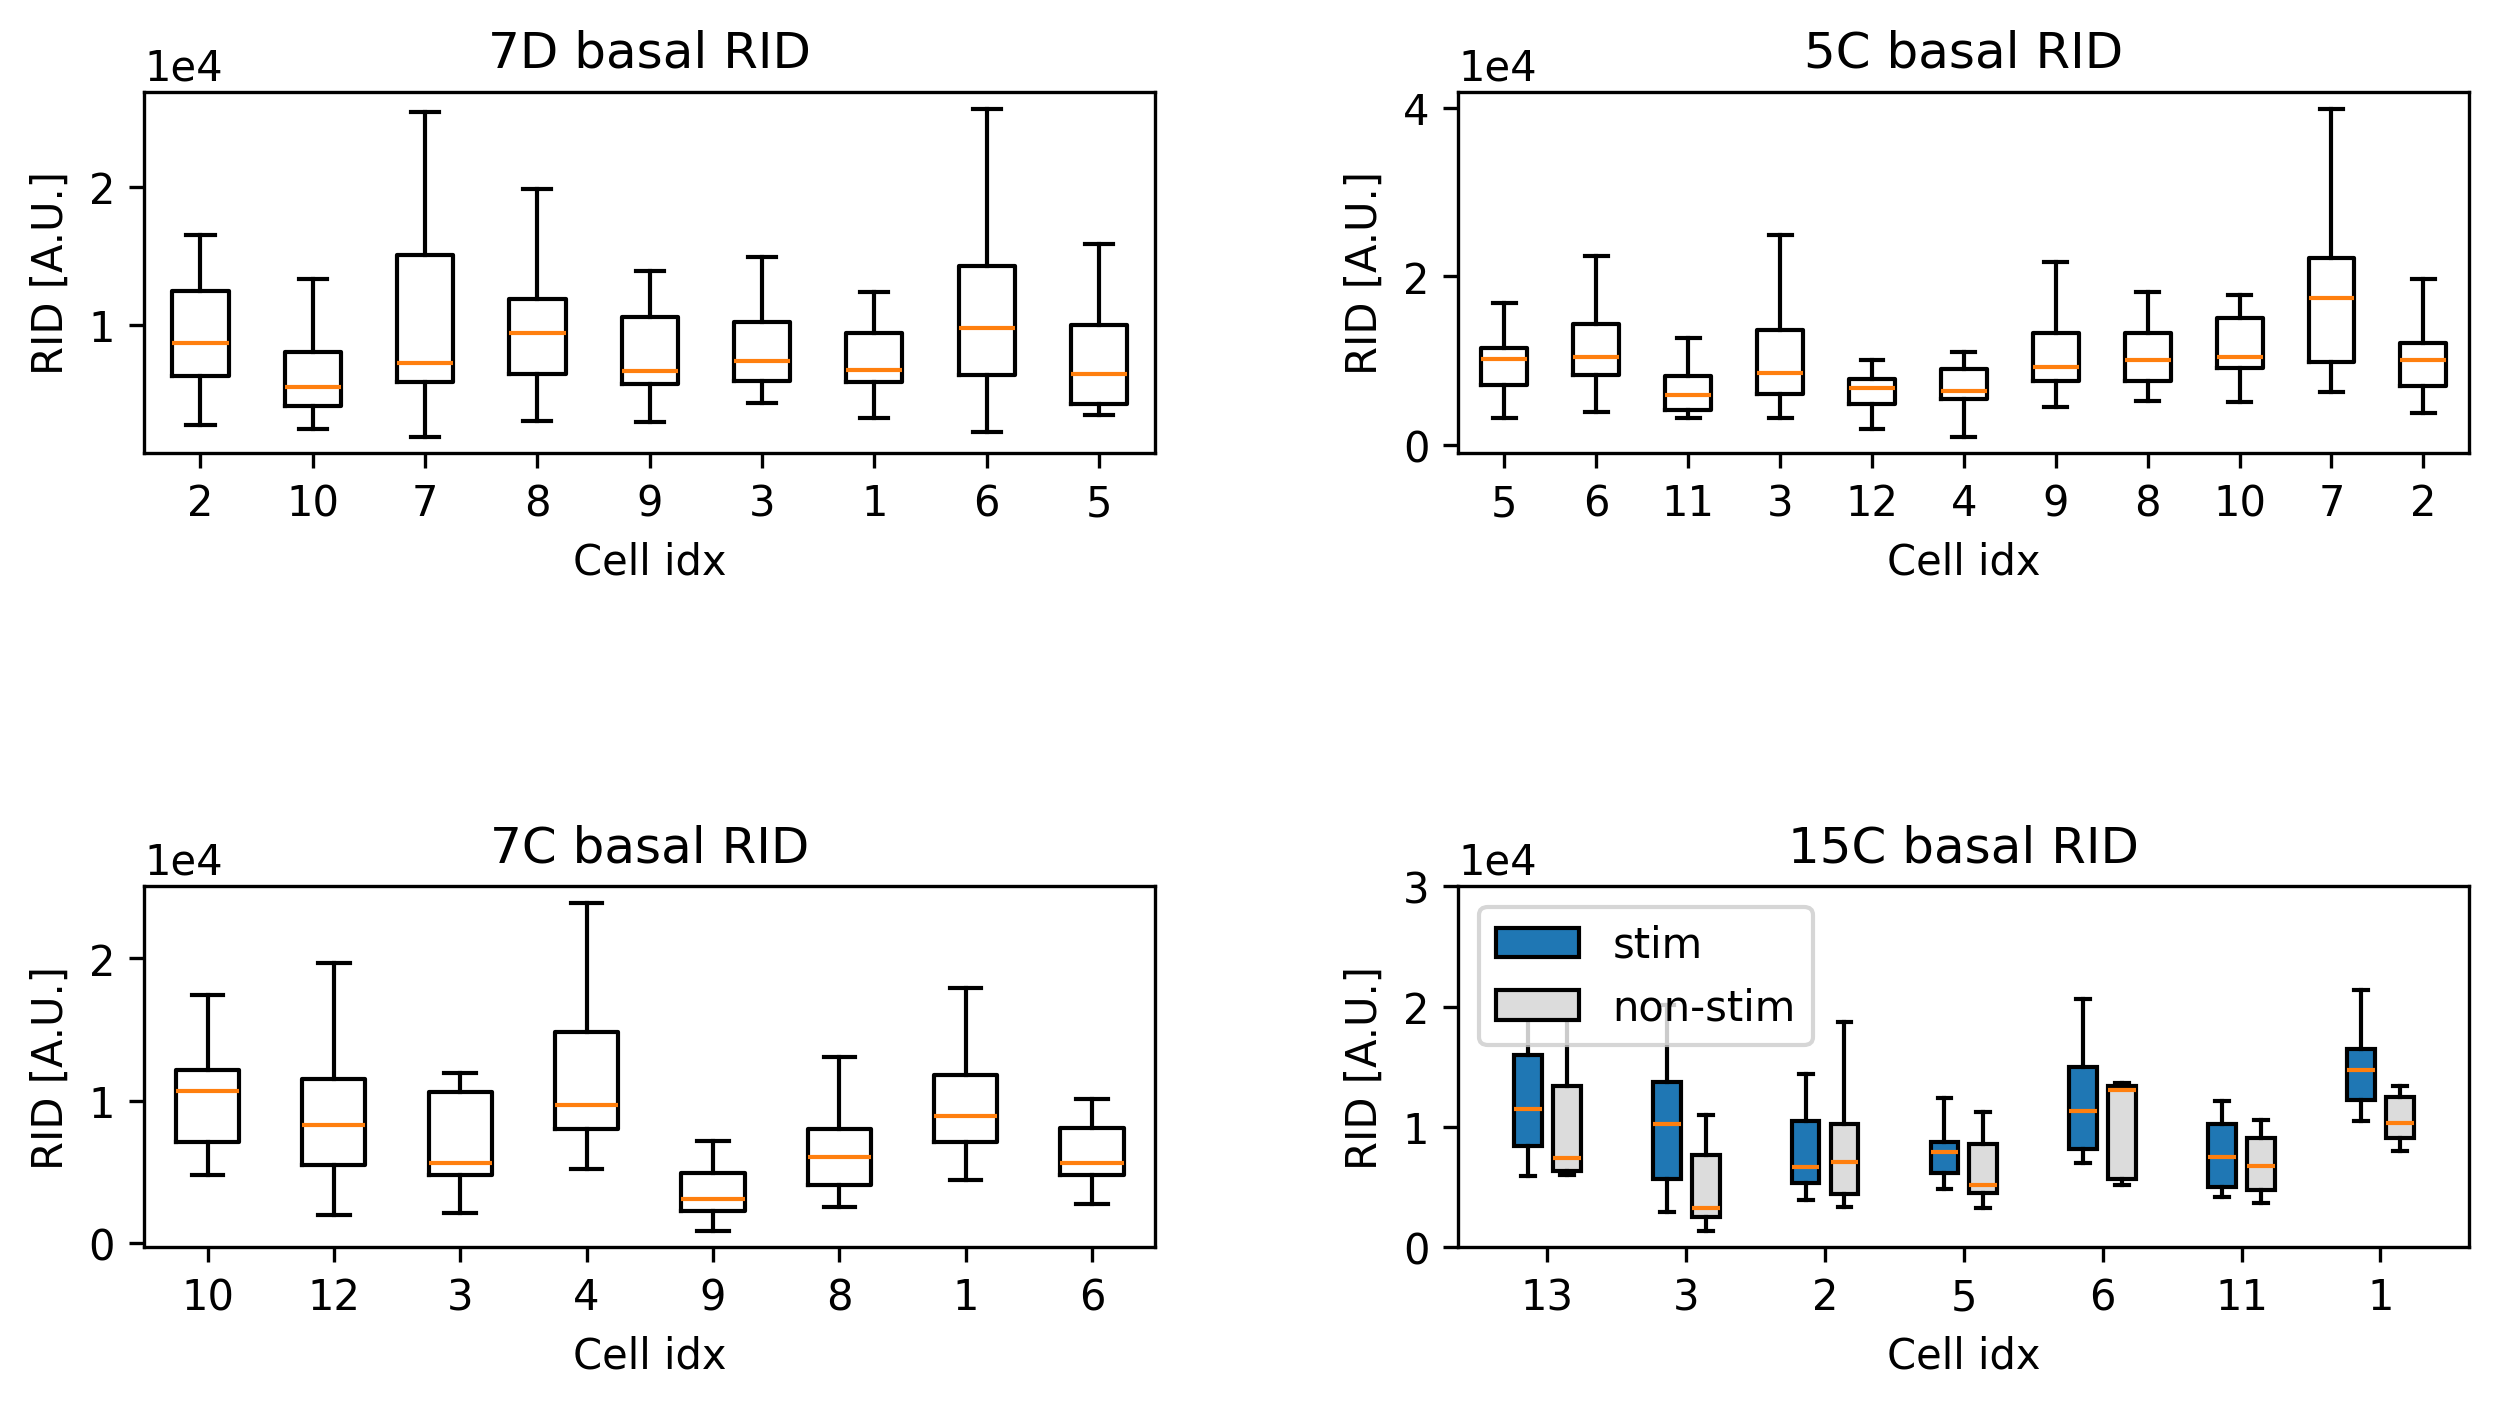

In [6]:
t_nss = [-1,5,7,15]
t_nss_labels = ['7D', '5C', '7C']

fig, axs = plt.subplots(2,2,figsize=(10,5), dpi=300)

# Baselines for 7D, 5C, 7C
for ax, nss, nss_label in zip(axs.flatten(), t_nss, t_nss_labels):
    dff = df[df['nss']==nss]
    base_sizes = {}

    for cell in dff['cell'].unique():
        dfc = dff[dff['cell']==cell]
        base_sizes[cell] = dfc['base_RID'].tolist()

    ax.boxplot(list(base_sizes.values()), showfliers=False);
    ax.set_xticklabels(base_sizes.keys());
    ax.set_xlabel('Cell idx')
    ax.set_ylabel('RID [A.U.]')
    ax.set_title(f'{nss_label} basal RID')
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))

# homo hetero baselines for 15C
dff = df[df['nss']==15]
stim_base_sizes = []
hetero_base_sizes = []
cells = dff['cell'].unique()

for cell in cells:
    dfc = dff[dff['cell']==cell]
    sbs = dfc[dfc['type']=='Stim']['base_RID'].tolist()
    hbs = dfc[dfc['type']=='Spine']['base_RID'].tolist()
    stim_base_sizes.append(sbs)
    hetero_base_sizes.append(hbs)

ax = axs[1,1]
positions = [i-0.14 for i in range(len(stim_base_sizes))]
bp1 = ax.boxplot(stim_base_sizes, positions=positions, widths=0.2,
            whis=(5,95), showfliers=False, patch_artist=True);


positions = [i+0.14 for i in range(len(stim_base_sizes))]
bp2 = ax.boxplot(hetero_base_sizes, positions=positions, widths=0.2,
            whis=(5,95), showfliers=False, patch_artist=True,
            boxprops=dict(facecolor='gainsboro'));

ax.set_xlabel('Cell idx')
ax.set_ylabel('RID [A.U.]')
ax.set_title('15C basal RID')
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['stim', 'non-stim'], loc='upper left')

ax.set_ylim(0,3e4)

plt.xticks([i for i in range(len(stim_base_sizes))], cells);
plt.subplots_adjust(hspace=1.2, wspace=0.3)


### Filtered database
With the previous findings (and some trial and error) we drop the following cells:
- 7 stimulations: cell 9
- 15 stimulations: cells 3, 5

We also include additional findings from the gather-data notebook
- 3 spines hyperbig intracluster spine
- biggest 15 stim spine

In [7]:
def filter_spine_df(df):
    '''
    Main filtering function.
    Do not move it to the top to be able to show how the data dropping improved
    the baseline conditions.

    This filter is manually copypasted into default_goda_filter and used throughout the
    rest of the pipeline
    '''
    fdf = df.copy()

    fdf.drop(fdf[(fdf['nss']==-1) & (
        (fdf['cell']=='10')
        # | (fdf['cell']=='3')
        # | (fdf['cell']=='4')
    )].index, inplace=True)

    fdf.drop(fdf[(fdf['nss']==5) & (
        (fdf['cell']=='7')
        # | (fdf['cell']=='3')
        # | (fdf['cell']=='4')
    )].index, inplace=True)

    fdf.drop(fdf[(fdf['nss']==7) & (
        (fdf['cell']=='9')
        | (fdf['cell']=='8')
    )].index, inplace=True)

    fdf.drop(fdf[(fdf['nss']==15) & (
        (fdf['cell']=='3')
        # | (fdf['cell'] == '5')
        | (fdf['cell'] == '6')
        | (fdf['cell'] == '13')
    )].index, inplace=True)

    # Drop the hyperbig 3 stim intracluster spine
    fdf.drop(fdf[fdf['nss']==3]['distance'].idxmin(), inplace=True)

    return fdf

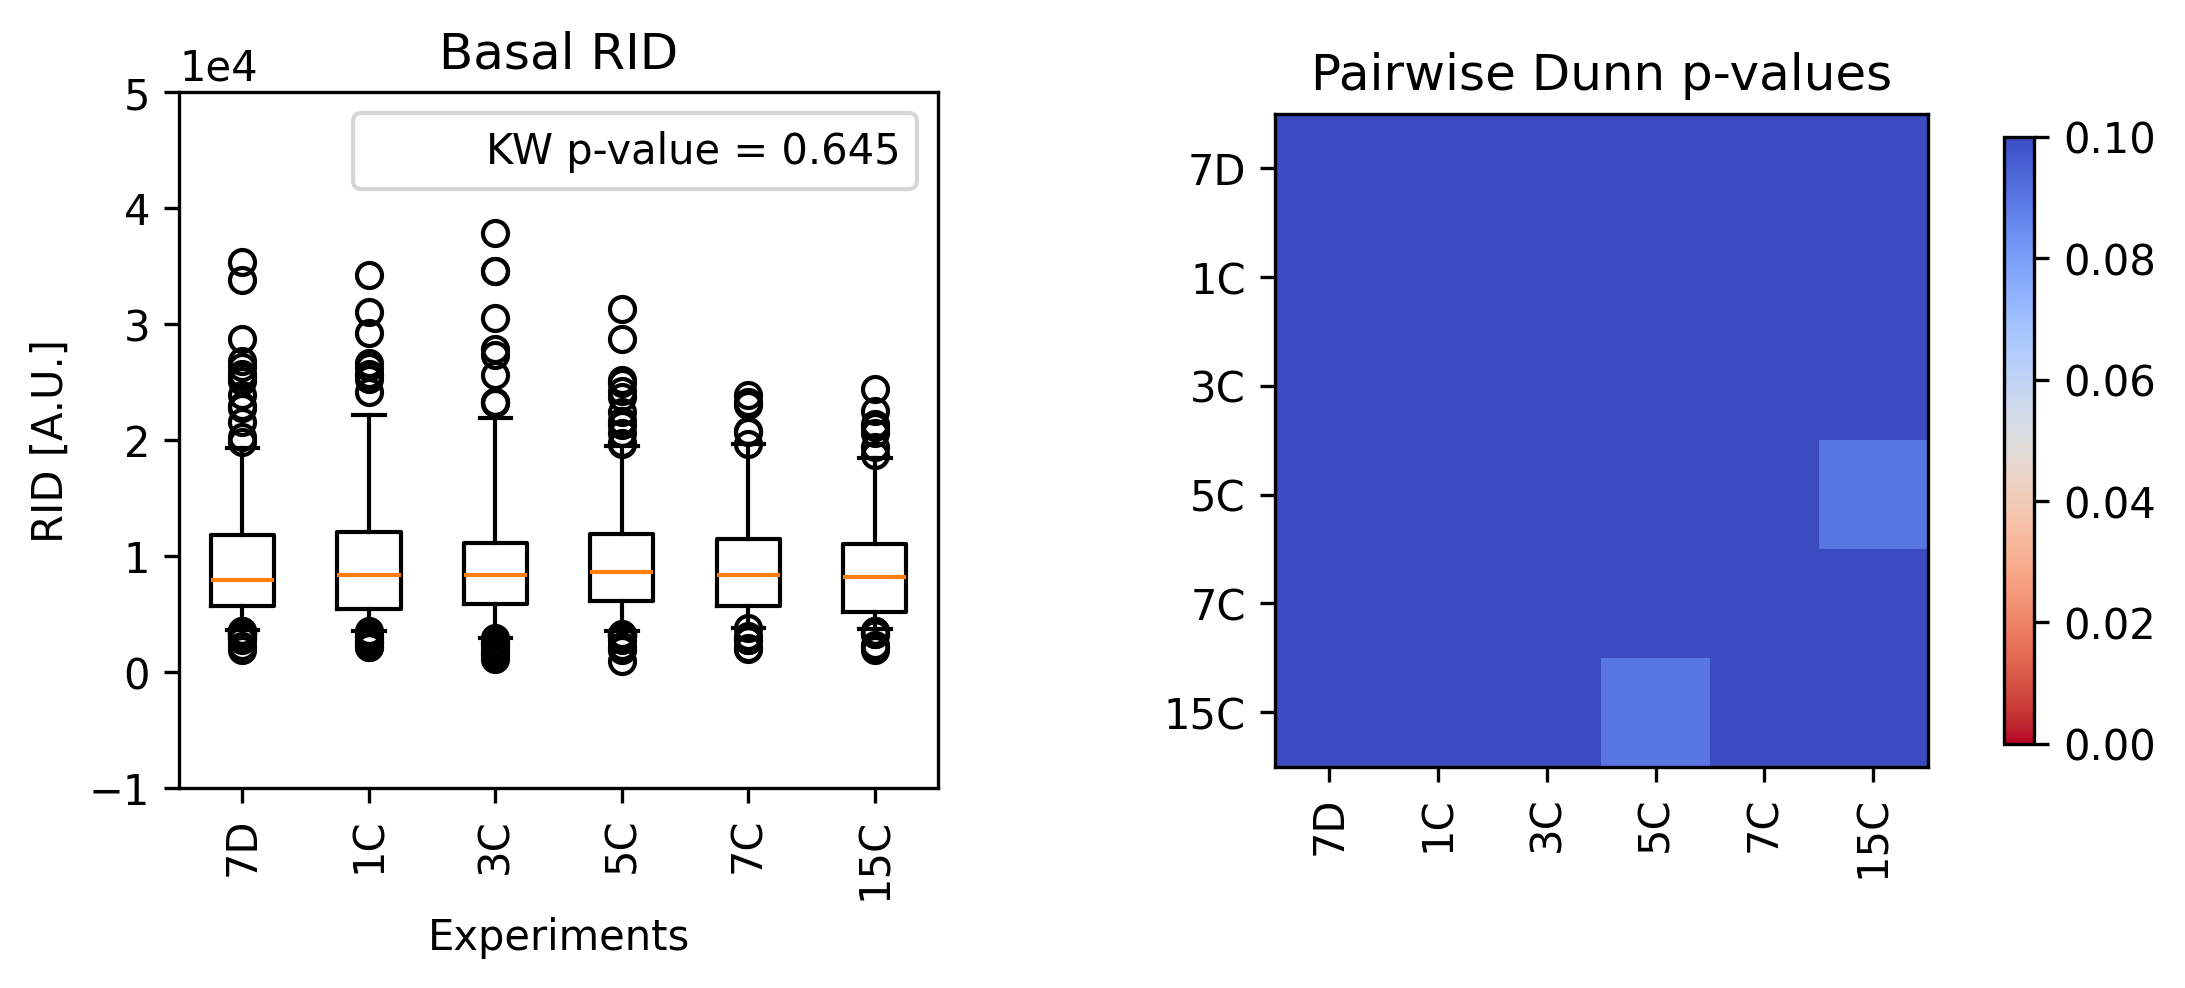

In [9]:
fdf = filter_spine_df(df)

base_homo_sizes = []
base_hetero_sizes = []
base_sizes = []

for nss in nsss:
    fdff = fdf[fdf['nss'] == nss]
    base_sizes.append(fdff['base_RID'].tolist())
    base_homo_sizes.append(fdff[fdff['type']=='Stim']['base_RID'].tolist())
    base_hetero_sizes.append(fdff[fdff['type']=='Spine']['base_RID'].tolist())

# Kruskar-Wallis for all the spine sizes in general
kw,_, axs = kruskal_dunn(base_sizes, nsss_labels, xlabel='Experiments', ylabel='RID [A.U.]',dpi=300);
axs[0].set_title('Basal RID');
axs[0].plot([], [], ' ', label=f'KW p-value = {kw.pvalue:.3f}')
axs[0].set_ylim(-1e4,5e4)
axs[0].legend()

# Test if the homo-ketero pairs come from the same distribution
for nss, homo, hetero in zip(nsss, base_homo_sizes, base_hetero_sizes):
    hh_ks = stats.kstest(homo, hetero)
    if hh_ks.pvalue < 0.05:
        print(f'{nss} p-value: {hh_ks.pvalue}')

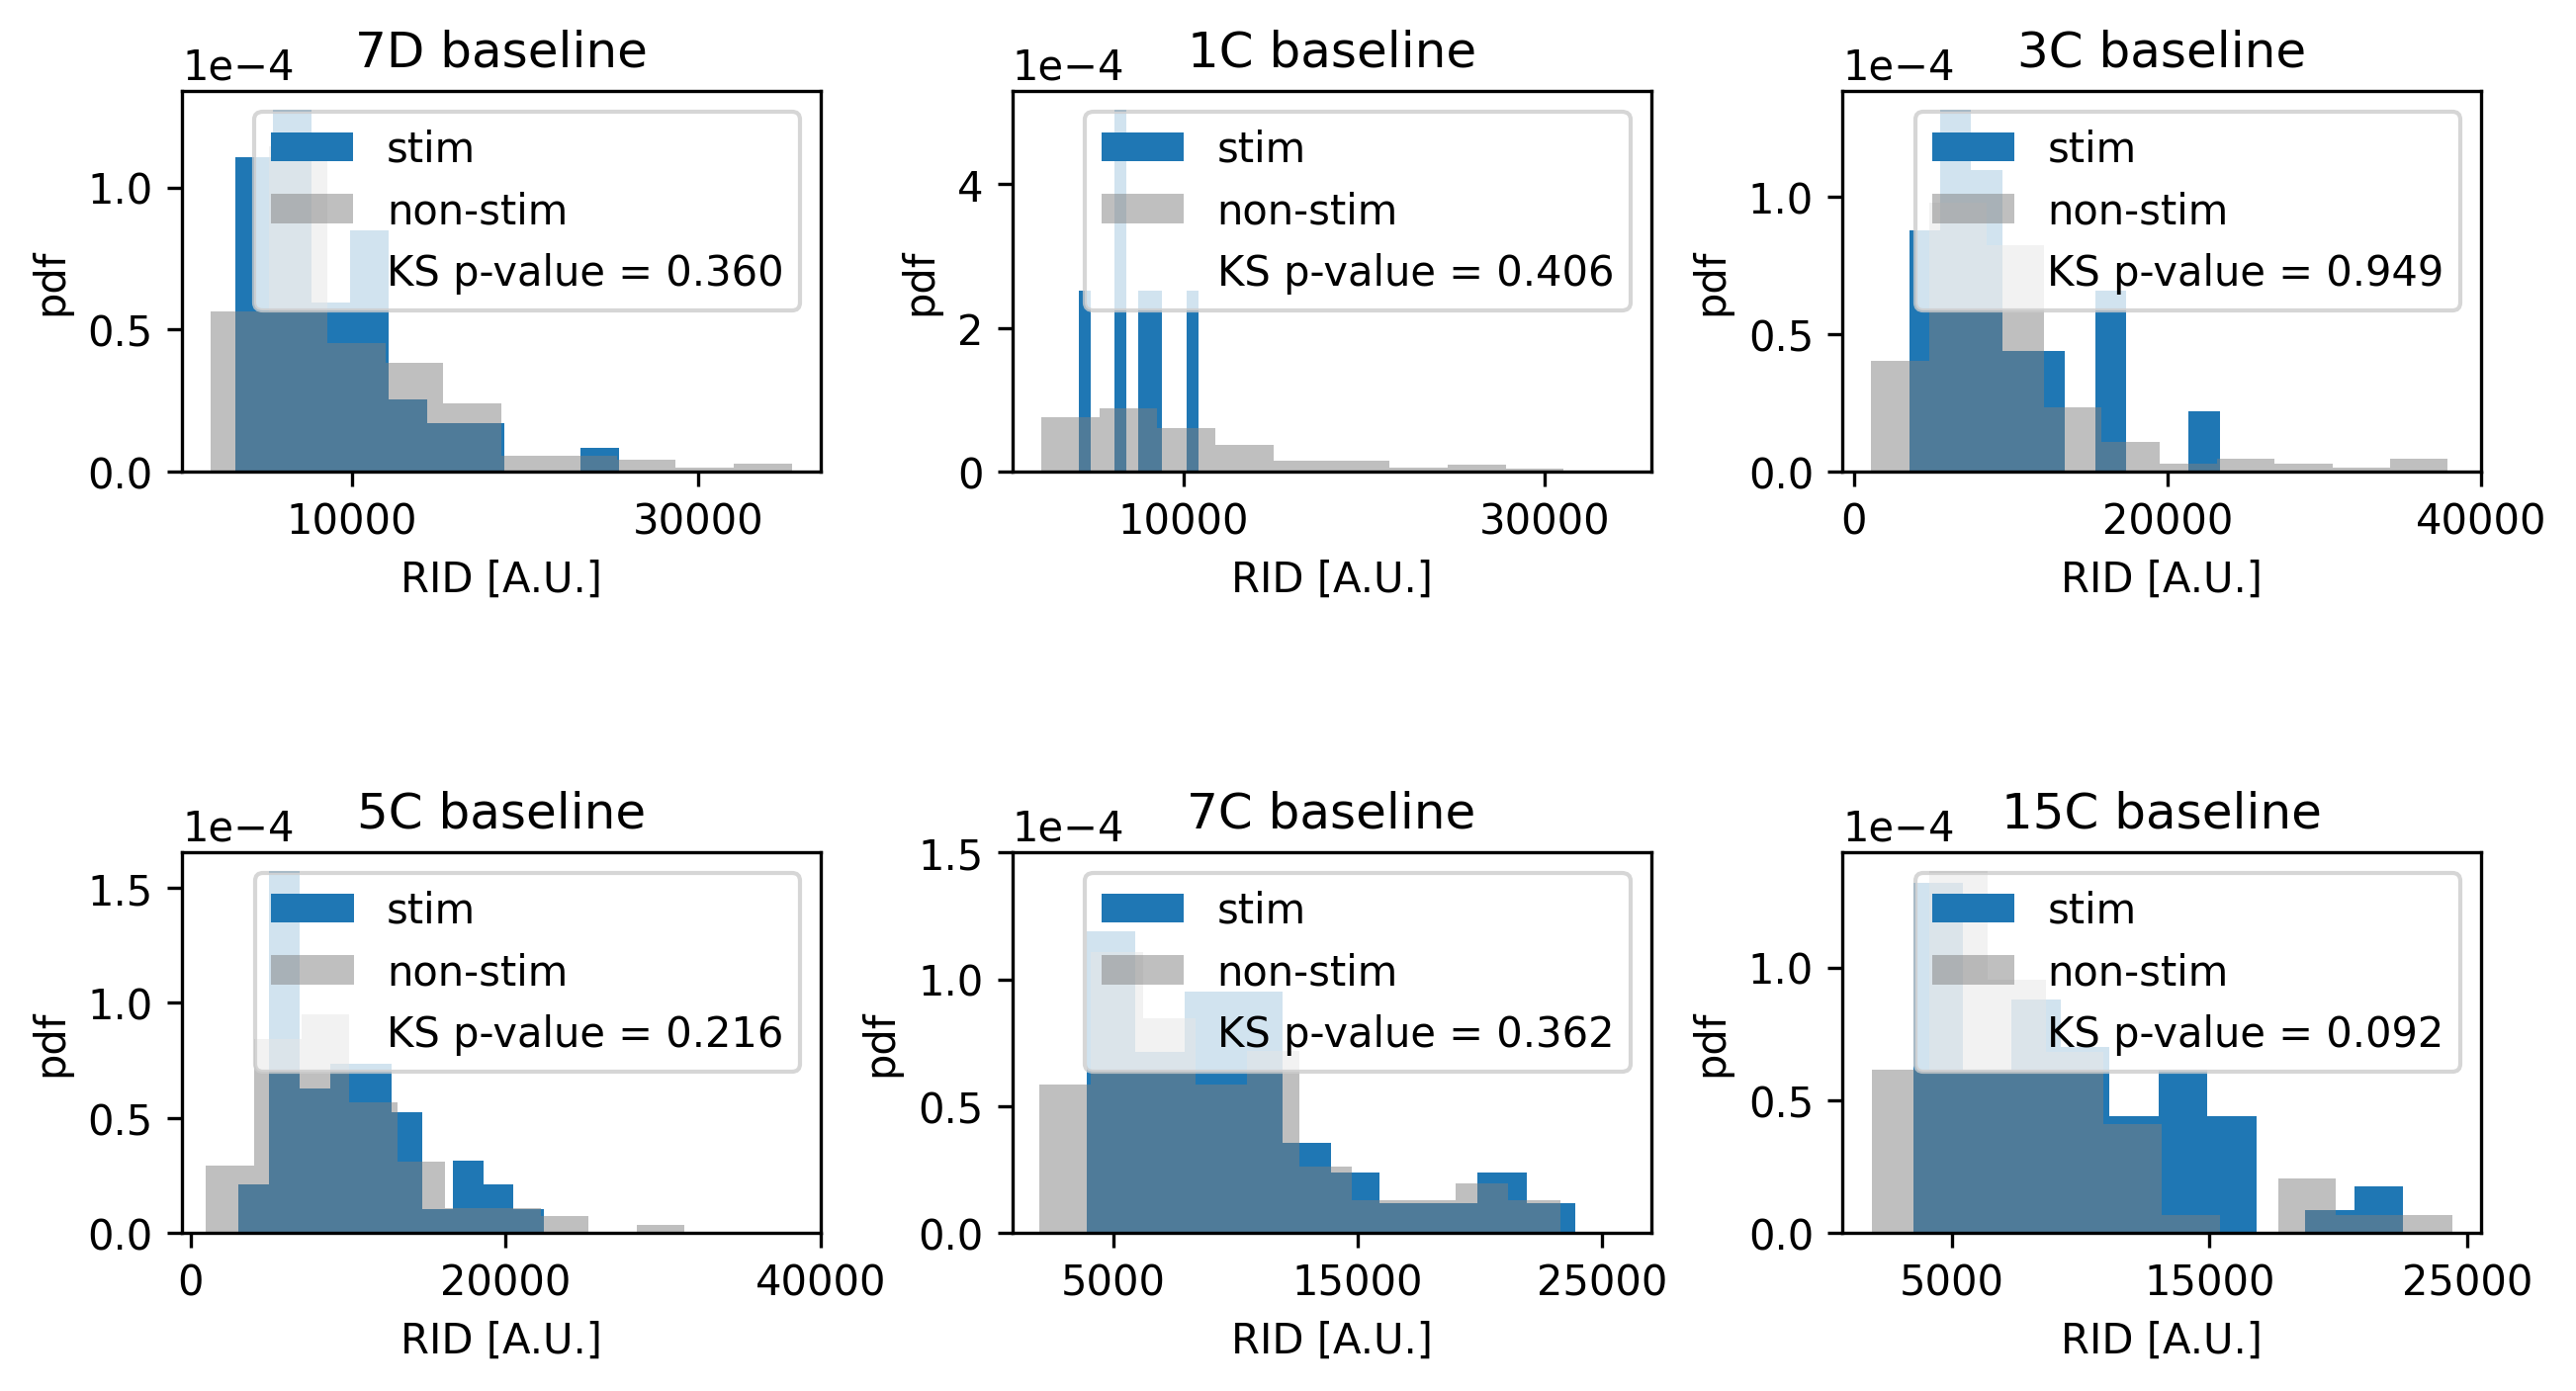

In [10]:
base_homo_sizes = []
base_hetero_sizes = []

for nss in nsss:
    fdff = fdf[fdf['nss'] == nss]
    base_homo_sizes.append(fdff[fdff['type']=='Stim']['base_RID'].tolist())
    base_hetero_sizes.append(fdff[fdff['type']=='Spine']['base_RID'].tolist())

fig, axs = plt.subplots(2,3, dpi=300, figsize=(10,5))

# Test if the homo-ketero pairs come from the same distribution
for ax, homo, hetero, nss in zip(axs.flatten(), base_homo_sizes, base_hetero_sizes, nsss_labels):
    hh_ks = stats.kstest(homo, hetero)

    ax.hist(homo, color='tab:blue', density=True, label='stim');
    ax.hist(hetero, color='gray', histtype='stepfilled', alpha=0.5, density=True, label='non-stim');
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    ax.plot([],[], ' ', label=f'KS p-value = {hh_ks.pvalue:.3f}')

    ax.set_xticks(ax.get_xticks()[1::2])

    ax.set_xlabel('RID [A.U.]')
    ax.set_ylabel('pdf')
    ax.set_title(f'{nss} baseline')

    ax.legend()

# Fine adjustments
axs[1,1].set_xlim(axs[1,1].get_xlim()[0], 27000)
axs[1,1].set_ylim(0,1.5e-4)
plt.subplots_adjust(wspace=0.3, hspace=1)

# Analysis
Use fdf from now on!

## Size-change relation

### Aux methods

In [11]:
def base_vs_rel_size_change(df, nss):
    '''
    Plots the base size vs relative size change charts.
    '''
    dff = df[df['nss']==nss]
    homo_dff = dff[dff['type']=='Stim']

    hetero_dff = dff[dff['type']!='Stim']

    # Stimulated spines
    fig, axs = plt.subplots(1,5, figsize=(12,2.2))
    fig.tight_layout(pad=1, rect=[0,0,1,0.85])
    x = np.linspace(0,homo_dff['base_RID'].max(),10)

    for idx, t in enumerate(t_post_stim):
        ax = axs[idx]
        s,i,r,p,_ = stats.linregress(homo_dff['base_RID'], homo_dff[f'delta_{t}'])
        sig = '*' if p<0.05 else 'n.s.'
        fit_color = 'tab:orange' if p<0.05 else 'gray'

        # homo_dff.plot.scatter(x='base_RID', y=f'delta_{t}', ax=ax, c='white', ec='gray')

        norm_delta = (homo_dff[f'delta_{t}'])/ homo_dff[f'base_RID']
        ax.scatter(homo_dff['base_RID'], norm_delta)

        ax.axhline(y=0, linestyle='--', linewidth=1)

        # ax.plot(x, s*x + i, c=fit_color, linewidth=2, label=f'R = {r:.2} {sig}')
        ax.axhline(y=1, linestyle='--', linewidth=0.5, c='gray')

        ax.set_title(f'{t} min')
        ax.set_xlabel(r'$S_0$')
        # ax.set_ylim(0,8)
        ax.set_ylabel('')
        ax.legend()

        ax.ticklabel_format(axis='both', style='scientific', scilimits=(0,0))

    fig.suptitle('Stimulated spines')
    axs[0].set_ylabel(r'$S_t-S_0$');


    # Heterosynaptic spines
    fig, axs = plt.subplots(1,5, figsize=(12,2.2))
    fig.tight_layout(pad=1, rect=[0,0,1,0.85])
    x = np.linspace(0,hetero_dff['base_RID'].max(),10)

    for idx, t in enumerate(t_post_stim):
        ax = axs[idx]
        s,i,r,p,_ = stats.linregress(hetero_dff['base_RID'], hetero_dff[f'delta_{t}'])
        sig = '*' if p<0.05 else 'ns'
        fit_color = 'tab:orange' if p<0.05 else 'gray'
        hetero_dff.plot.scatter(x='base_RID', y=f'delta_{t}', ax=ax, c='white', ec='gray')
        ax.plot(x, s*x + i, c=fit_color, linewidth=2, label=f'R = {r:.2} {sig}')
        ax.axhline(y=1, linestyle='--', linewidth=0.5, c='gray')

        ax.set_title(f'{t} min')
        ax.set_xlabel(r'$S_0$')
        # ax.set_ylim(0,8)
        ax.set_ylabel('')
        ax.legend()
        ax.ticklabel_format(axis='both', style='scientific', scilimits=(0,0))

    fig.suptitle('Unstimulated spines')
    axs[0].set_ylabel(r'$S_t - S_0$');



In [12]:
def f(x,a,b,c):
    return -(10**a*x) + 10**b

def loss(p, x, y, yerr):
    return (f(x,*p) - y)/yerr

def stim_norm_delta_at_2(df, nsss):
    '''
    Plots the base size vs relative size change charts.
    '''

    # nsss = df['nss'].unique()
    # nsss = [3,5,7,15]
    t = 2

    fig, axs = plt.subplots(1,len(nsss),figsize=(4*len(nsss),3), dpi=300)
    fig.tight_layout(rect=[0.05, 0.05, 1, 1])

    if not isinstance(axs, list):
        axs = [axs]

    for ax, nss in zip(axs, nsss):
        # dff = df[df['nss']==nss]

        dff = df

        homo_dff = dff[dff['type']=='Stim'][['base_RID',f'{t}']]

        
        homo_dff['bin'] = pd.cut(homo_dff['base_RID'], [0,5e3, 1e4, 1.5e4, 2e4, 2.5e4, 3e4])

        b_homo_dff = homo_dff.groupby('bin').agg(
            {
                'base_RID' : ['mean', 'std', 'count'],
                f'{t}' : ['mean', 'std', 'count']
            }
        ).dropna()

        b_homo_dff[f'base_RID','sem'] = b_homo_dff[f'base_RID','std']/np.sqrt(b_homo_dff[f'base_RID','count'])
        b_homo_dff[f'{t}','sem'] = b_homo_dff[f'{t}','std']/np.sqrt(b_homo_dff[f'{t}','count'])

        base = homo_dff['base_RID']
        delta = homo_dff[f'{t}']

        b_base = b_homo_dff['base_RID', 'mean']
        b_base_std = b_homo_dff['base_RID', 'std']
        b_base_sem = b_homo_dff['base_RID', 'sem']

        b_delta = b_homo_dff[f'{t}', 'mean']
        b_delta_std = b_homo_dff[f'{t}', 'std']
        b_delta_sem = b_homo_dff[f'{t}', 'sem']

        X = base
        Y = delta/base
        dummy_yerr = np.ones_like(Y)

        b_X = b_base
        b_Y = b_delta/b_base
        b_Y_err = b_Y * (b_base_sem/b_base + b_delta_sem/b_delta)
    
        X_line = np.linspace(X.min()-1000, X.max()+1000, 100)

        if nss == 1:
            res_lsq = least_squares(loss, [-1.,-1.,1.], args=(X,Y, dummy_yerr))
            ax.scatter(X, Y, c='gray', s=10)
            ax.plot(X_line, f(X_line, *res_lsq.x), c='tab:blue')
            ax.axhline(y=0, c='gray', linewidth=1, linestyle='--')

        else:
            # res_lsq = least_squares(loss, [-1.,-1.,1.], args=(b_X,b_Y, b_Y_err))

            # ax.plot(X_line, f(X_line, *res_lsq.x), c='black', linewidth=2, label='model fit')

            ax.scatter(X, Y, alpha=0.5, c='black', s=10, edgecolors='gray', label='data')

            ax.axhline(y=0, c='black', linewidth=1, linestyle='--')

            ax.set_xlabel('Base RID')
            ax.set_ylabel('Normalized post-pre RID')

            ax.legend(frameon=False)

        ax.locator_params(axis='x', nbins='2')
        # ax.set_title(f'# Stimulations = {nss}')

    # plt.savefig('/home/janko/code/phd/rdn-project/docs/paper/src/figures/results/3_stim_depression.png')





/tmp/ipykernel_241944/494355588.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  b_homo_dff = homo_dff.groupby('bin').agg(


Text(0.5, 1.0, 'Plasticity in stimulated spines')

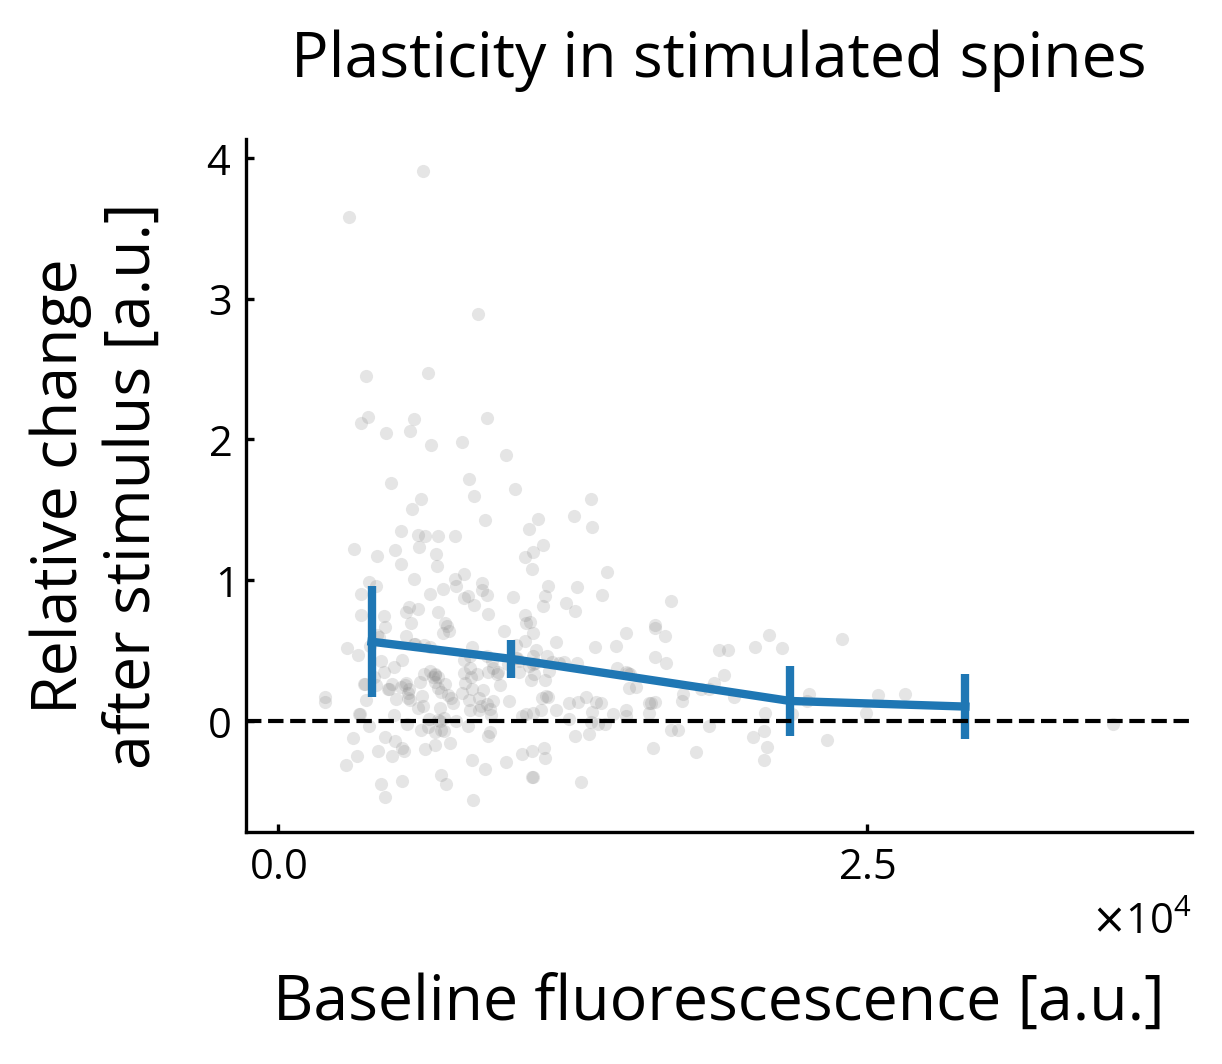

In [21]:
def temp_stim_norm_delta_at_2(df, nsss):
    '''
    Plots the base size vs relative size change charts.
    '''

    # nsss = df['nss'].unique()
    # nsss = [3,5,7,15]
    t = 2

    fig, axs = plt.subplots(1,len(nsss),figsize=(4*len(nsss),3), dpi=300)
    fig.tight_layout(rect=[0.05, 0.05, 1, 1])

    if not isinstance(axs, list):
        axs = [axs]

    for ax, nss in zip(axs, nsss):
        # dff = df[df['nss']==nss]

        dff = df

        homo_dff = dff[dff['type']=='Stim'][['base_RID',f'delta_{t}']]

        
        homo_dff['bin'] = pd.cut(homo_dff['base_RID'], [0,5e3, 2e4, 2.5e4,5e4])

        b_homo_dff = homo_dff.groupby('bin').agg(
            {
                'base_RID' : ['mean', 'std', 'count'],
                f'delta_{t}' : ['mean', 'std', 'count']
            }
        ).dropna()

        b_homo_dff[f'base_RID','sem'] = b_homo_dff[f'base_RID','std']/np.sqrt(b_homo_dff[f'base_RID','count'])
        b_homo_dff[f'delta_{t}','sem'] = b_homo_dff[f'delta_{t}','std']/np.sqrt(b_homo_dff[f'delta_{t}','count'])

        base = homo_dff['base_RID']
        delta = homo_dff[f'delta_{t}']

        b_base = b_homo_dff['base_RID', 'mean']
        b_base_std = b_homo_dff['base_RID', 'std']
        b_base_sem = b_homo_dff['base_RID', 'sem']

        b_delta = b_homo_dff[f'delta_{t}', 'mean']
        b_delta_std = b_homo_dff[f'delta_{t}', 'std']
        b_delta_sem = b_homo_dff[f'delta_{t}', 'sem']

        X = base
        Y = delta/base
        dummy_yerr = np.ones_like(Y)

        b_X = b_base
        b_Y = b_delta/b_base
        b_Y_err = b_Y * (b_base_sem/b_base + b_delta_sem/b_delta)*3
    
        X_line = np.linspace(X.min()-1000, X.max()+1000, 100)

        if nss == 1:
            # res_lsq = least_squares(loss, [-1.,-1.,1.], args=(X,Y, dummy_yerr))
            ax.scatter(X, Y,
                       c='gray',
                       s=10,
                       alpha=0.2, linewidths=0)
            ax.errorbar(b_X, b_Y, b_Y_err,
                        linewidth=2,
                        elinewidth=2)
            # ax.plot(X_line, f(X_line, *res_lsq.x), c='tab:blue')
            ax.axhline(y=0, c='black', linewidth=1, linestyle='--')

        else:
            # res_lsq = least_squares(loss, [-1.,-1.,1.], args=(b_X,b_Y, b_Y_err))

            # ax.plot(X_line, f(X_line, *res_lsq.x), c='black', linewidth=2, label='model fit')

            ax.scatter(X, Y, 
                       alpha=0.2, 
                       c='black', 
                       s=10,
                       edgecolors='gray',
                       label='data')

            ax.axhline(y=0, c='black', linewidth=1, linestyle='--')

            ax.set_xlabel('Base RID')
            ax.set_ylabel('Normalized post-pre RID')

            ax.legend(frameon=False)

        ax.locator_params(axis='x', nbins='2')
        # ax.set_title(f'# Stimulations = {nss}')

    # plt.savefig('/home/janko/code/phd/rdn-project/docs/paper/src/figures/results/3_stim_depression.png')
temp_stim_norm_delta_at_2(df, [1])

ax = plt.gca()
ax.set_xlabel('Baseline fluorescescence [a.u.]', labelpad=20)
ax.set_ylabel('Relative change\nafter stimulus [a.u.]')
ax.set_title('Plasticity in stimulated spines')

### 1 stimulation


/tmp/ipykernel_241944/1033377807.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


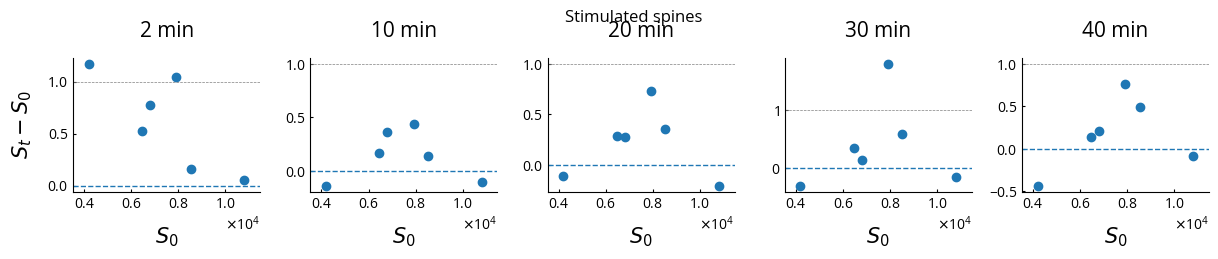

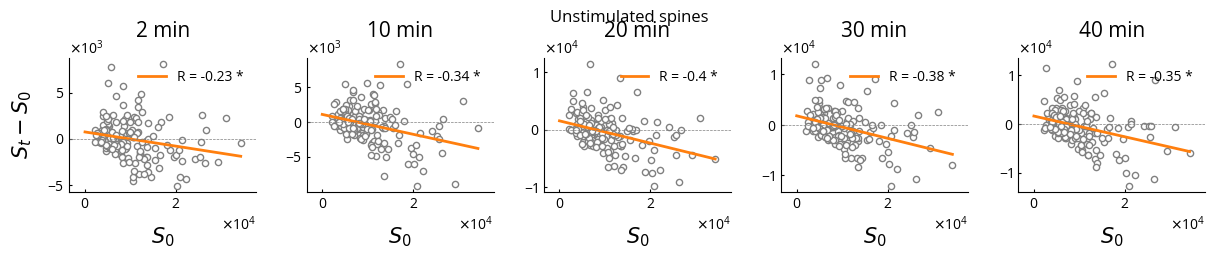

In [23]:
base_vs_rel_size_change(fdf, 1)

/tmp/ipykernel_241944/1033377807.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


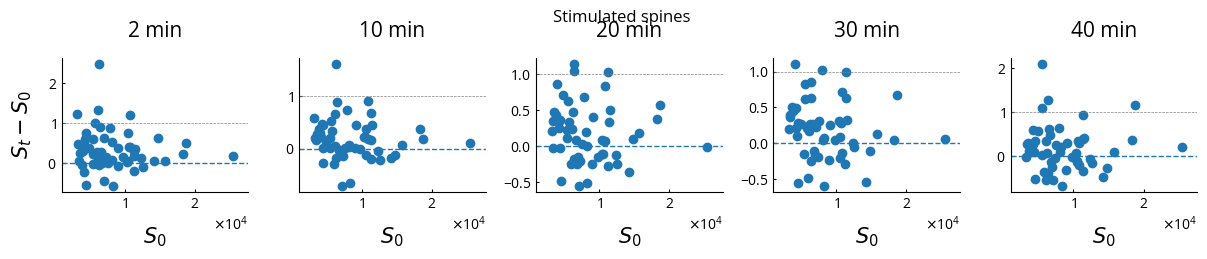

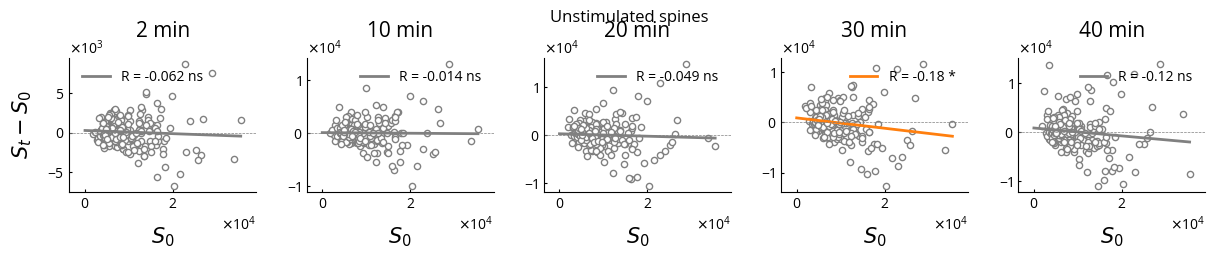

In [24]:
base_vs_rel_size_change(fdf, -1)

### 3 stimulations


/tmp/ipykernel_241944/1033377807.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


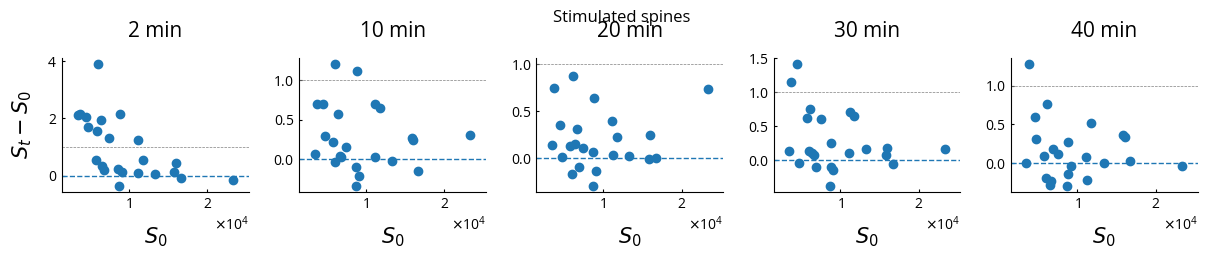

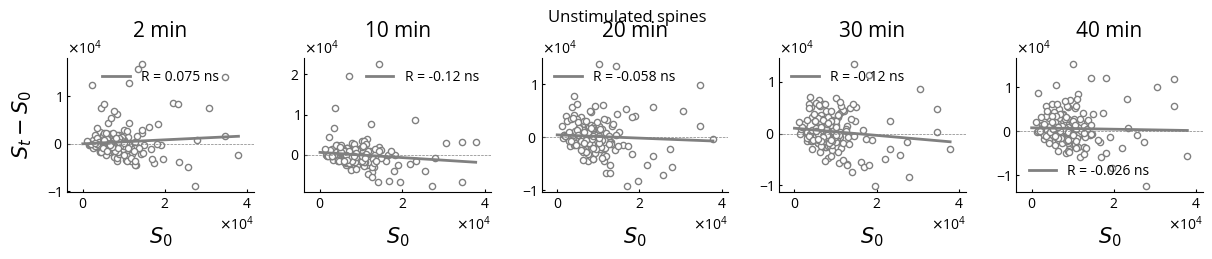

In [25]:
base_vs_rel_size_change(fdf, 3)

/tmp/ipykernel_241944/1033377807.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


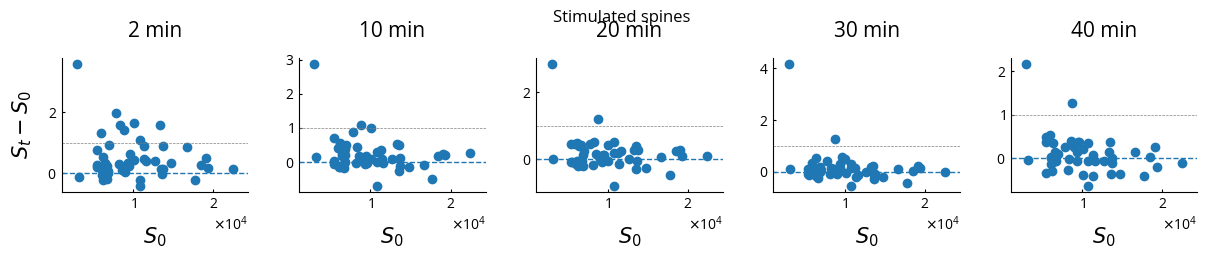

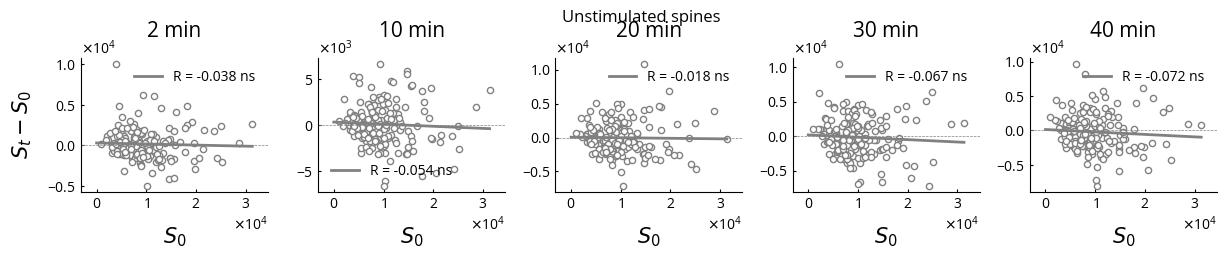

In [26]:
base_vs_rel_size_change(fdf, 5)

### 7 stimulations

/tmp/ipykernel_241944/1033377807.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


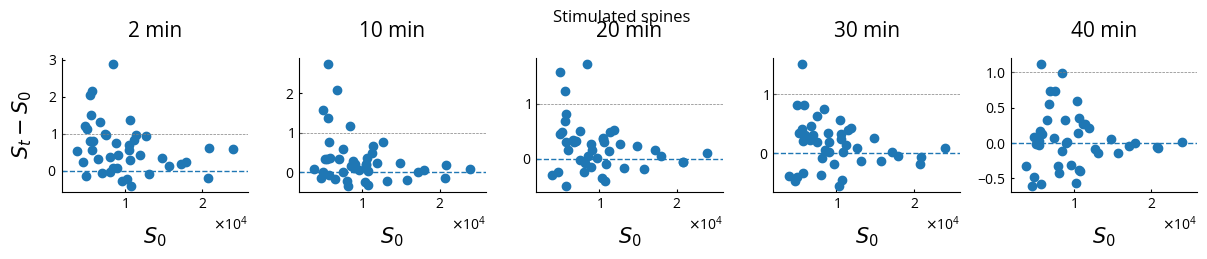

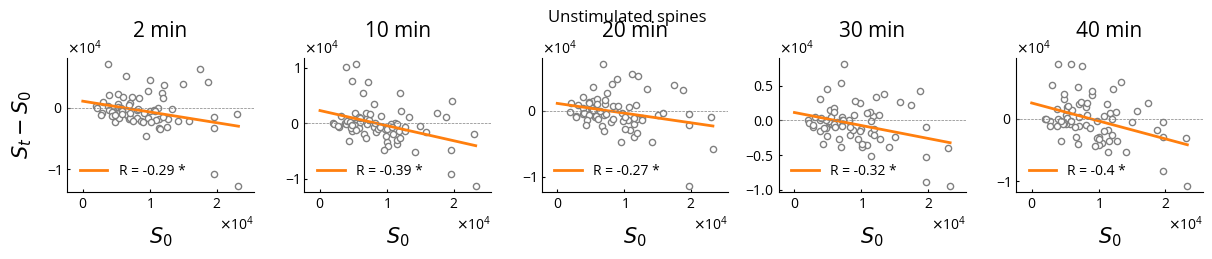

In [27]:
base_vs_rel_size_change(fdf, 7)

### 15 stimulations

/tmp/ipykernel_241944/1033377807.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


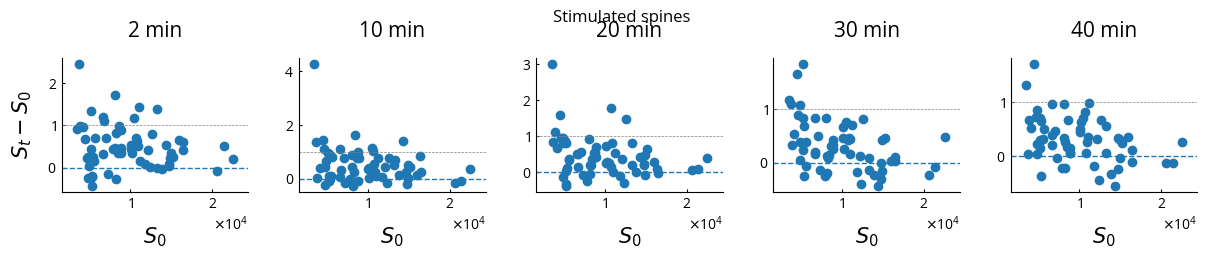

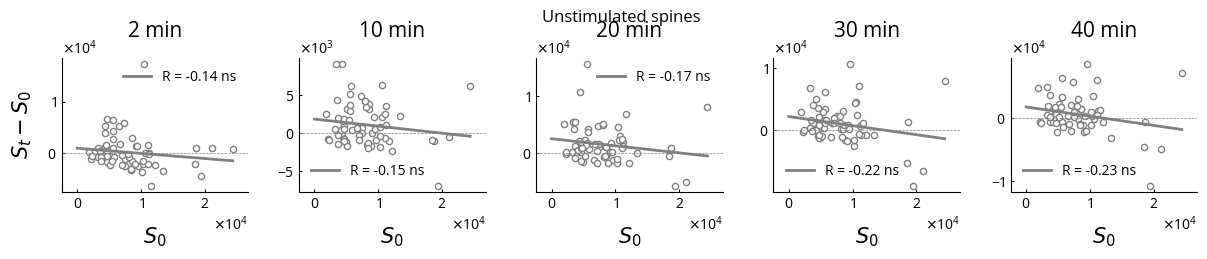

In [28]:
base_vs_rel_size_change(fdf, 15)

## Stim-hetero rel change (Oh 2015)
Looks like we are not really getting that baseline vs 40 mins!!

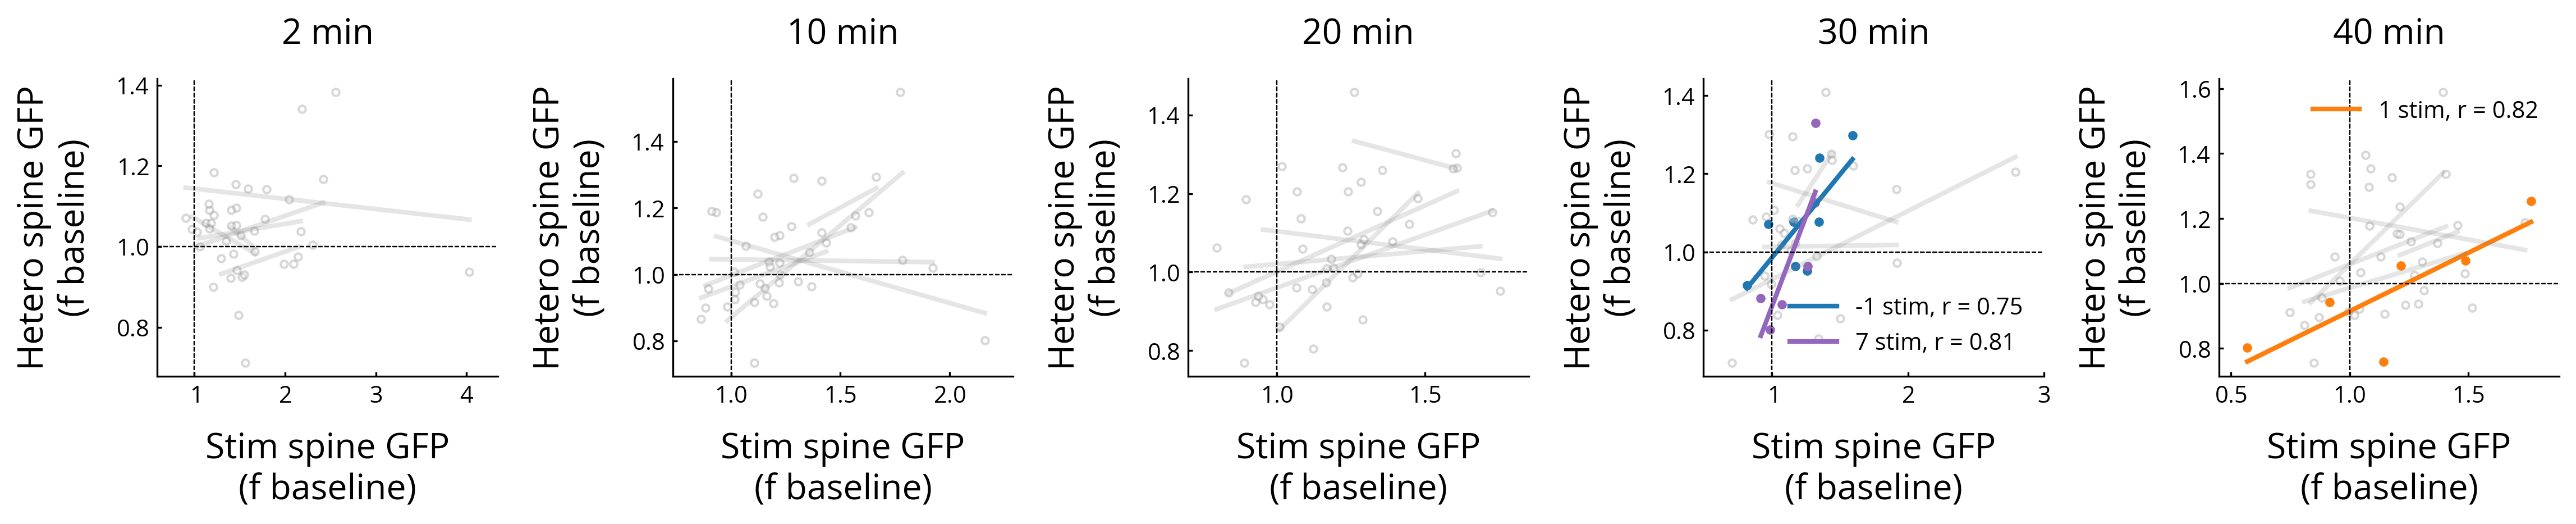

In [29]:
fig, axs = plt.subplots(1,5,figsize=(20,4), dpi=300)
fig.tight_layout(pad=5, rect=[0.1,0.1,0.9,0.95])
# fig.suptitle(r'Fig. 1E (40 min), Oh et al. 2015')

for ax, t in zip(axs, ['2','10','20','30','40']):
    for nss in nsss:

        dff = fdf[fdf['nss']==nss]

        homos = []
        heteros = []

        for cell in dff['cell'].unique():
            cdff = dff[dff['cell'] == cell]

            homo = cdff[cdff['type']=='Stim'][f'norm_{t}'].to_numpy()
            hetero = cdff[(cdff['type']!='Stim')
                # & (cdff['distance']>0)
                & (cdff['distance']<=10)
            ][f'norm_{t}']

            homos.append(homo.mean())
            heteros.append(hetero.mean())

        homos = np.stack(homos, axis=0)
        heteros = np.stack(heteros, axis=0)

        s,i,r,p,e = stats.linregress(homos, heteros)
        
        
        points = ax.scatter(homos, heteros, marker='.')

        x = np.linspace(homos.min(), homos.max(), 10)
        y = s*x + i

        if p<0.05:
            c = points.get_facecolor()
            ax.plot(x,y, label=f'{nss} stim, r = {r:.2}',c=c)
            ax.legend()
        else:
            ax.plot(x,y,c='gray', alpha=0.2)
            points.set_facecolor('white')
            points.set_edgecolor('gray')
            points.set_alpha(0.3)

        ax.axhline(y=1, linestyle='--', c='black', linewidth=0.5)
        ax.axvline(x=1, linestyle='--', c='black', linewidth=0.5)

        ax.set_title(f'{t} min')
        ax.set_xlabel('Stim spine GFP\n(f baseline)')
        ax.set_ylabel('Hetero spine GFP\n(f baseline)')

    

## Size autocorrelation
Let's see if we can get some information out of the correlation for the stochastic model. We do our testing on the sham data as clearly there is no stationarity after stimulation.
Theoretically, we schould check that the conditions for ergodicity apply!

Text(1409.9247406750194, 0.5, 'Pearson r coefficient')

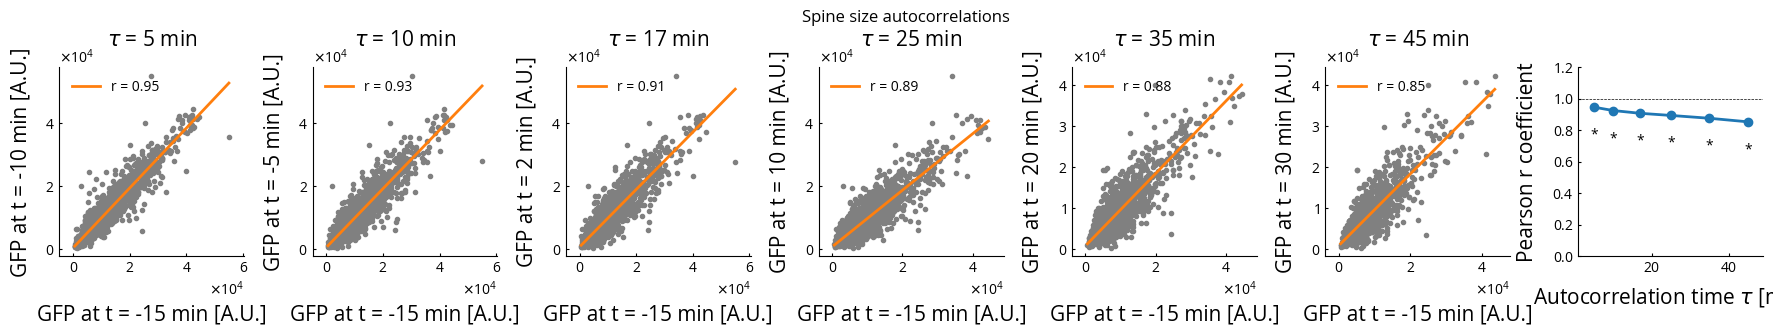

In [30]:
tau_steps = [1,2,3,4,5,6]
taus = [5,10,17,25,35,45]

fig, axs = plt.subplots(1,7, figsize=(18,3))
fig.tight_layout(pad=2, rect=[0,0,1,0.9])
fig.suptitle('Spine size autocorrelations')

rids = np.stack(sdf['egglRID'].tolist(), axis=0).T

corrs = []
for ax, tau_step, tau in zip(axs, tau_steps, taus):
    s, i, r, p, e = stats.linregress(rids[:-tau_step].flatten(), rids[tau_step:].flatten())
    x = np.linspace(rids[:-tau_step].flatten().min(), rids[:-tau_step].flatten().max(), 10)
    y = x*s + i

    corrs.append(r)

    ax.scatter(rids[:-tau_step].flatten(), rids[tau_step:].flatten(), c='gray', marker='.')
    ax.plot(x,y, c='tab:orange', linewidth=2, label=f'r = {r:.2}')
    ax.set_title(r'$\tau$ = '+f'{tau} min')
    ax.set_xlabel('GFP at t = -15 min [A.U.]')
    ax.xaxis.labelpad = 20
    ax.set_ylabel(f'GFP at t = {tau - 15} min [A.U.]')
    ax.ticklabel_format(axis='both', style='scientific', scilimits=(0,0))
    ax.legend()

ax = axs[-1]
ax.plot(taus, corrs)
ax.scatter(taus, corrs)

for x, y in zip(taus, corrs):
    ax.text(x-1,y-0.2, s='*')

ax.axhline(y=1, linewidth=0.5, linestyle='--', c='black')
ax.set_ylim(0,1.2)
ax.set_xlabel(r'Autocorrelation time $\tau$ [min]')
ax.xaxis.labelpad = 7
ax.set_ylabel(r'Pearson r coefficient')




## Spine density

/tmp/ipykernel_526015/677195362.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,idx].legend()


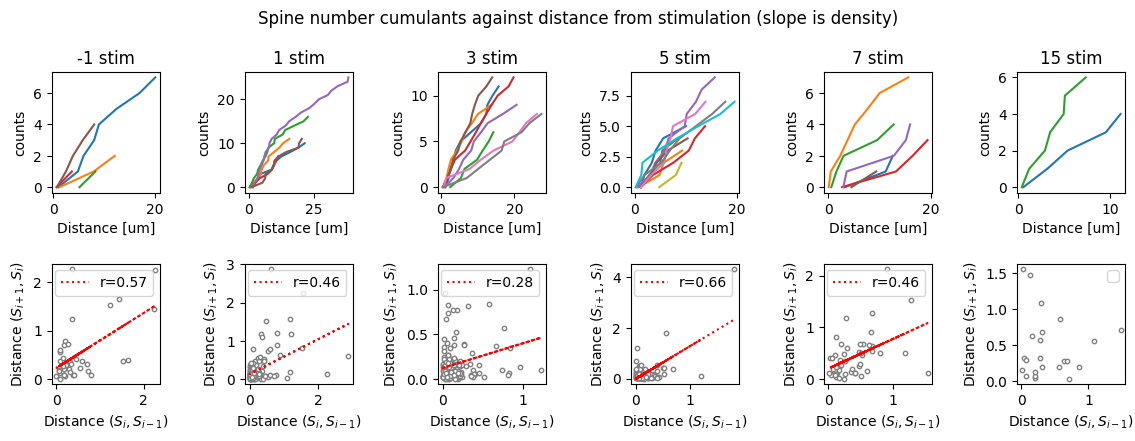

In [13]:
fig, axs = plt.subplots(2,6,figsize=(15,5))
fig.tight_layout(pad=3, rect=[0.1, 0.1, 0.9, 0.95])
fig.suptitle('Spine number cumulants against distance from stimulation (slope is density)')

for idx, nss in enumerate(nsss):
    dff = fdf[fdf['nss']==nss]
    cells = dff['cell'].unique()

    ss = []
    ii = []
    ees = []
    eei = []

    for cell in cells:
        dffc = dff[(dff['cell'] == cell) & (dff['distance']>0)].sort_values('distance')
        dffc = dffc.iloc[::2]
        x = dffc['distance'].sort_values().to_numpy()
        y = np.arange(0,dffc.shape[0])

        # Plot the cumulative function
        axs[0,idx].plot(x, y)

    axs[0,idx].set_title(f'{nss} stim')
    axs[0,idx].set_xlabel('Distance [um]')
    axs[0,idx].set_ylabel('counts')

    # Check if the next and previous relative didstance are correlated.
    # If positively, it could be an attention effect (spines located far
    # from the last one will have even further next neighbours)
    x = dff[dff['distance']>0]['distance'].sort_values().to_numpy()
    delta_x = x[1:] - x[:-1]
    res = stats.linregress(delta_x[:-1], delta_x[1:])
    s,i,r,p,e = res

    axs[1,idx].scatter(delta_x[:-1], delta_x[1:], s=10, c='white', edgecolor='gray')
    if p<0.05: axs[1, idx].plot(delta_x[:-1], delta_x[:-1]*s + i, c='red', linestyle=':', label=f'r={r:.2}')
    axs[1,idx].set_xlabel(r'Distance $(S_i, S_{i-1})$')
    axs[1,idx].set_ylabel(r'Distance $(S_{i+1}, S_{i})$')
    axs[1,idx].legend()


How do we evaluate the mean distance between spines? We cite Jammalamadaka 2013, Chen 2022 - National Science Review, and Mr Chandrashekhar himself probably, and we fit the experiments with normalized Weibulls with centered `loc` parameter, and compute the mean with 
$$
\mathbb{E}[x] =\lambda \, \Gamma\left(1+\frac{1}{k}\right)
$$

## Potentiation hats
Lets see if our data has the mexican hat.
There is an issue with the most internal spine for 3 stims; i did not consider that spine in the fitting process.

/home/janko/code/phd/rdn-project/src/rdn/defaults/binbydistance.py:79: UserWarning: 13.5, 16.5 there is a 1 point bin! Associating 10% error
  warnings.warn(msg)
/home/janko/code/phd/rdn-project/src/rdn/defaults/binbydistance.py:79: UserWarning: 15.0, 18.0 there is a 1 point bin! Associating 10% error
  warnings.warn(msg)
/home/janko/code/phd/rdn-project/src/rdn/defaults/binbydistance.py:79: UserWarning: 18.0, 21.0 there is a 1 point bin! Associating 10% error
  warnings.warn(msg)
/home/janko/code/phd/rdn-project/src/rdn/defaults/binbydistance.py:79: UserWarning: 19.5, 22.5 there is a 1 point bin! Associating 10% error
  warnings.warn(msg)
/home/janko/code/phd/rdn-project/src/rdn/defaults/binbydistance.py:79: UserWarning: 10.5, 13.5 there is a 1 point bin! Associating 10% error
  warnings.warn(msg)


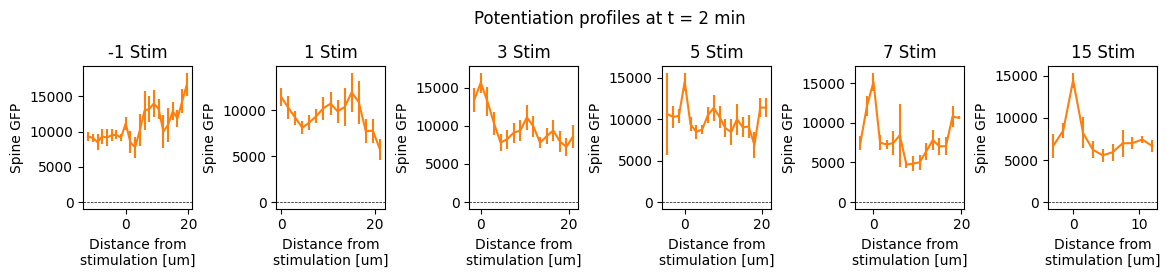

In [14]:
from rdn.defaults import bin_by_distance

fig, axs = plt.subplots(1,6,figsize=(15,3), dpi=100)
fig.tight_layout(pad=3, rect=[0.1, 0.1, 0.9, 0.95])
fig.suptitle('Potentiation profiles at t = 2 min')

for ax, nss in zip(axs, nsss):
    dff = fdf[fdf['nss']==nss]
    # dff = dff[dff['distance']>=0]
    dff = dff[dff['distance']<20]

    binned = bin_by_distance(df=dff, 
                            bin_key='2',
                            bin_width=3,
                            bin_stride=1.5,
                            stim_at_zero=True)

    y = np.stack(binned['mean'].to_list(), axis=0)
    y_err = np.stack(binned['stderr'].to_list(), axis=0)
    x = binned['distance'].to_numpy()

    ax.errorbar(x,y,yerr=y_err, c='tab:orange')
    ax.axhline(y=1, linewidth=0.5, linestyle='--', c='black')

    # ax.set_ylim(0.5, 2.2)

    ax.set_title(f'{nss} Stim')
    ax.set_xlabel('Distance from\nstimulation [um]')
    ax.set_ylabel('Spine GFP')



# Fitting

## Comparison basal vs stimulated masses

[ 1  3  5  7 15]
[ 1  3  5  7 15]
[ 1  3  5  7 15]


Text(-4, 12500.0, 'c.')

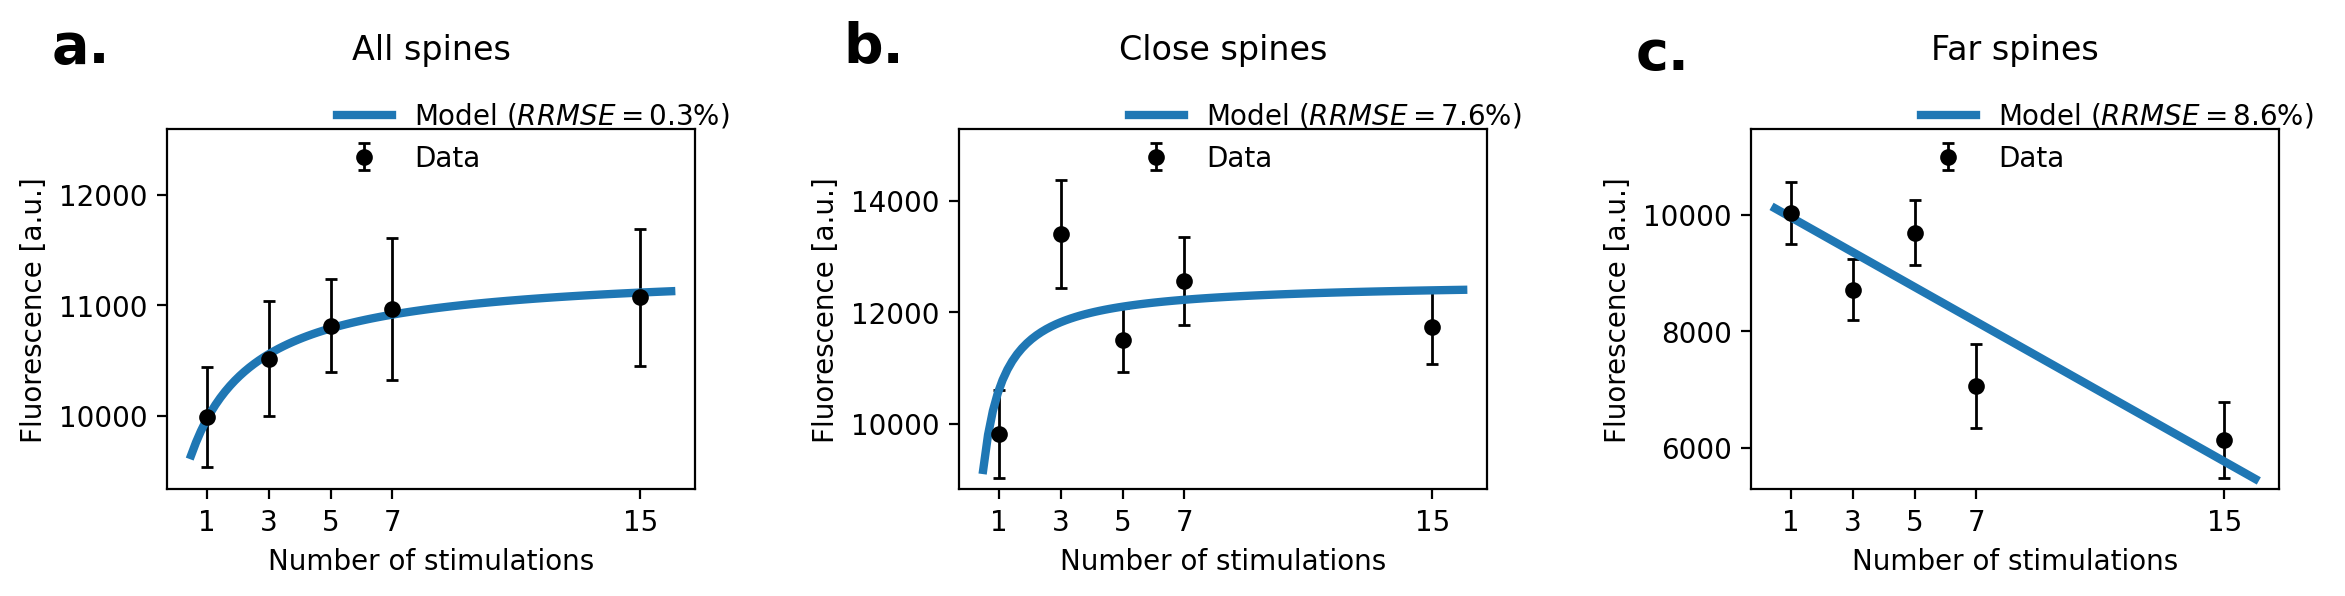

In [15]:
# After stimulus
t_point = '2'
close_th = 4

# RID
tot_RID_per_nss = []
stim_RID_per_nss = []
close_RID_per_nss = []
far_RID_per_nss = []


for nss in nsss:
    fdff = fdf[fdf['nss']==nss]
    sfdff = fdff[fdff['type']=='Stim']
    cfdff = fdff[fdff['distance'] <= close_th]
    ffdff = fdff[fdff['distance'] > close_th]

    # After stimulus
    tot_RID_per_nss.append(fdff[f'{t_point}'].to_list())
    stim_RID_per_nss.append(sfdff[f'{t_point}'].to_list())

    close_RID_per_nss.append(cfdff[f'{t_point}'].to_list())
    far_RID_per_nss.append(ffdff[f'{t_point}'].to_list())



def f_tot(x,a,b,c,d):
    return (10**a + b*x)/ (10**c * x + d)

def f_close(x,a,b,c,d):
    return (a*x)/(10**b + c*x)

def f_far(x,a,b,c,d):
    return (10**a - 10**b * x)/(10**c + 10**d*x)

def loss(p, f, x, y, yerr):
    return (f(x,*p) - y)**2/yerr**2


# Fitplot: the classic method where I give him some RID list of lists,
# he parses it into numpy, takes means and errs, fits and plots

def fit_plot(ax, f, X, data, title):
    Y = np.array([np.mean(d) for d in data])
    Y_err = np.array([np.std(d)/np.sqrt(len(d)) for d in data])

    # Plotting limit
    y_range = [
        (Y - Y_err).min() - 200,
        (Y + Y_err).max() + 900,
    ]
    

    print(X)
    res = least_squares(loss, [1.,1.,1.,1.], args=(f,X,Y, Y_err))
    X_fit = np.linspace(0.5, 16, 100)
    Y_fit = f(X_fit, *res.x) 
    Y_pred = f(X, *res.x)


    rmse = np.sqrt(((Y - Y_pred)**2).sum())
    rrmse = np.sqrt(((Y-Y_pred)**2).sum()/(Y**2).sum())*100
    nrmse = rmse/Y_err
    
    ax.errorbar(X, Y, Y_err, 
                fmt='.', c='black', markersize=10, linewidth=1, capsize=2,
                label='Data')

    ax.plot(X_fit, Y_fit,
            linewidth=3, 
            label=r'Model ($RRMSE = {:.1f}\%$)'.format(rrmse))

    ax.set_ylim(y_range)
    

    ax.legend(frameon=False, loc=[0.3,.85], fontsize=10)
    ax.set_xticks(X)
    ax.set_title(title, pad=25)



fig, axs = plt.subplots(1,3, figsize=(12,3), dpi=200)
fig.subplots_adjust(wspace=0.5, top=0.8, bottom=0.2, left=0.1, right=0.98)

ax = axs[0]
fit_plot(ax,
         f_tot,
         nsss[1:],
         tot_RID_per_nss[1:],
         'All spines')

ax = axs[1]
fit_plot(ax,
         f_close,
         nsss[1:],
         close_RID_per_nss[1:],
         'Close spines')

ax = axs[2]
fit_plot(ax,
         f_far,
         nsss[1:],
         far_RID_per_nss[1:],
         'Far spines')

for ax in axs:
    ax.set_xlabel('Number of stimulations')
    ax.set_ylabel('Fluorescence [a.u.]')

axs[0].text(-4,1.32e4,'a.', weight='bold', size=20)
axs[1].text(-4,1.65e4,'b.', weight='bold', size=20)
axs[2].text(-4,1.25e4,'c.', weight='bold', size=20)

# plt.savefig('docs/figures/results/global_plasticity.png', dpi=300)


[1.21494832 0.05663311]


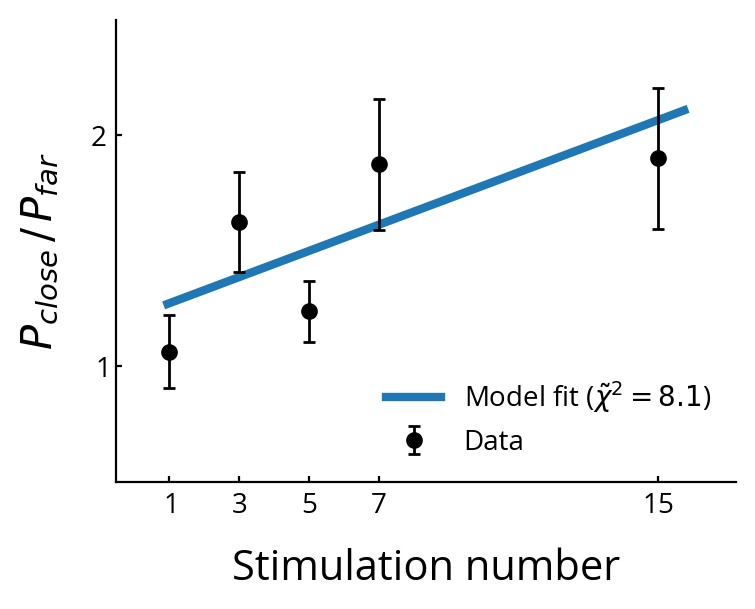

In [35]:
# After stimulus
t_point = '2'
close_th = 3

# RID
tot_RID_per_nss = []
stim_RID_per_nss = []
close_RID_per_nss = []
far_RID_per_nss = []


for nss in nsss:
    fdff = fdf[fdf['nss']==nss]
    sfdff = fdff[fdff['type']=='Stim']
    cfdff = fdff[fdff['distance'] <= close_th]
    ffdff = fdff[fdff['distance'] > close_th]

    # After stimulus
    tot_RID_per_nss.append(fdff[f'{t_point}'].to_list())
    stim_RID_per_nss.append(sfdff[f'{t_point}'].to_list())

    close_RID_per_nss.append(cfdff[f'{t_point}'].to_list())
    far_RID_per_nss.append(ffdff[f'{t_point}'].to_list())



def f_taylor(x,p):

    Y = 0.

    for power, pp in enumerate(p):
        Y += pp * x**power 
    
    return Y

def loss(p, x, y):
    return (f_taylor(x,p) - y)**2


# Fitplot: the classic method where I give him some RID list of lists,
# he parses it into numpy, takes means and errs, fits and plots

from scipy.stats import linregress

def fit_plot_close_vs_far(X, data_close, data_far):
    Y_close = np.array([np.mean(d) for d in data_close])
    Y_close_err = np.array([np.std(d)/np.sqrt(len(d)) for d in data_close])

    Y_far = np.array([np.mean(d) for d in data_far])
    Y_far_err = np.array([np.std(d)/np.sqrt(len(d)) for d in data_far])

    Y = Y_close/Y_far
    Y_err = (Y_close_err/Y_close + Y_far_err/Y_far)*Y

    

    res = least_squares(loss, [1.,1.], args=(X, Y))
    X_fit = np.linspace(0.95*X.min(), 1.05*X.max(), 100)
    Y_fit = f_taylor(X_fit, res.x) 

    Y_pred = f_taylor(X, res.x)
    redchi = (((Y - Y_pred)/Y_err)**2).sum()


    fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)
    ax.errorbar(X, Y, Y_err,
                fmt='.', c='black', markersize=10, linewidth=1, capsize=2,
                zorder=10,
                label='Data')


    ax.plot(X_fit, Y_fit, linewidth=3, 
            label=r'Model fit ($\tilde{{\chi}}^2 = {:.2}$)'.format(redchi))
    ax.set_xticks(X)
    
    ax.set_ylim(0.5,2.5)
    ax.set_yticks([1.,2.,])

    ax.legend(frameon=False)
    ax.set_xlabel('Stimulation number')
    ax.set_ylabel(r'$P_{close}\, / \,P_{far}$')

    print(res.x)


fit_plot_close_vs_far(nsss[1:],
                      close_RID_per_nss[1:], 
                      far_RID_per_nss[1:])
    


## Spine size considerations

We explore the behaviour of both the native sizes and their logarithms.
Log-logistic (and the logistic) seem to fit reasonably well the relative distributions while the same canno be said for the log-normal. Surprisingly, the normal fits very well the logarythm of the sizes -> is there a fitting problem with SciPy? Maybe I should Mr. Prof. friend of Stas.

In [36]:
res = multifit_distribution(df['base_RID']);
log_y = np.log(df['base_RID'].to_numpy())
log_res = multifit_distribution(log_y);


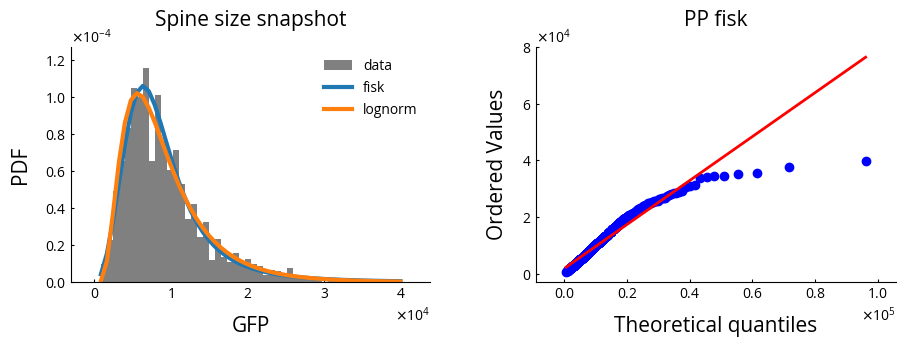

In [37]:
dist_name = 'fisk'
dist = eval(f'stats.{dist_name}')

fig, axs = plt.subplots(1,2,figsize=(10,4))
fig.tight_layout(pad=5)

vals, bins, _ = axs[0].hist(df['base_RID'], bins=50, density=True, color='gray', label='data')
axs[0].plot(bins, dist.pdf(bins, *res[dist_name]), c='tab:blue', linewidth=3, label=dist_name)
axs[0].plot(bins, stats.lognorm.pdf(bins, *res['lognorm']), c='tab:orange', linewidth=3, label='lognorm')
axs[0].set_ylim(0, vals.max()*1.1)
axs[0].set_title('Spine size snapshot')
axs[0].set_xlabel(r'GFP')
axs[0].set_ylabel('PDF')
axs[0].ticklabel_format(axis='both', style='scientific', scilimits=(0,0))
axs[0].legend()

stats.probplot(df['base_RID'], dist=dist_name, sparams=res[dist_name], plot=axs[1])
axs[1].ticklabel_format(axis='both', style='scientific', scilimits=(0,0))
axs[1].set_title(f'PP {dist_name}');

# stats.probplot(df['base_RID'], dist='lognorm', sparams=res['lognorm'], plot=axs[2])
# axs[2].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
# axs[2].set_title(f'PP lognorm');


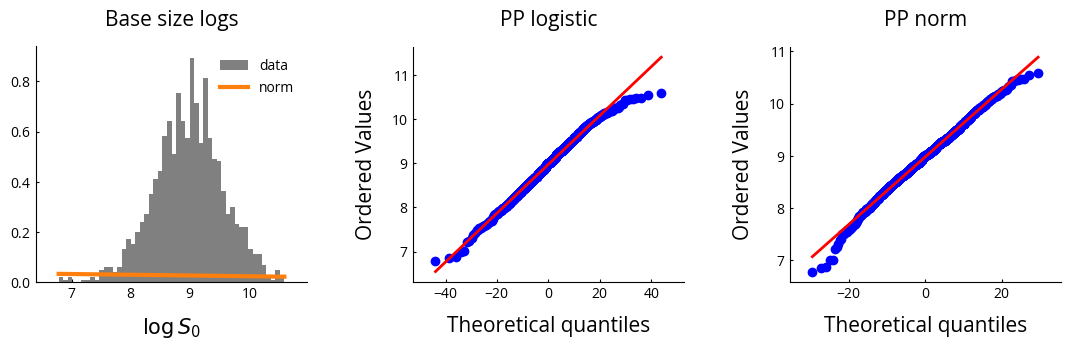

In [38]:
dist_name = 'norm'
dist = eval(f'stats.{dist_name}')

fig, axs = plt.subplots(1,3,figsize=(12,4))
fig.tight_layout(pad=5)

_, bins, _ = axs[0].hist(log_y, bins=50, density=True, color='gray', label='data')
# axs[0].plot(bins, stats.logistic.pdf(bins, *log_res['logistic']), c='tab:blue', linewidth=3, label='logistic')
axs[0].plot(bins, stats.norm.pdf(bins, *log_res['norm']), c='tab:orange', linewidth=3, label='norm', linestyle='-')
axs[0].set_title('Base size logs')
# axs[0].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
axs[0].set_xlabel(r'$\log S_0$')
axs[0].legend()


stats.probplot(log_y, dist='logistic', sparams=log_res['logistic'], plot=axs[1]);
axs[1].set_title('PP logistic')

stats.probplot(log_y, dist='norm', sparams=log_res['norm'], plot=axs[2]);
axs[2].set_title('PP norm');

It seems that the logarythms are very well fitted by a gaussian function though. Is it possible that SciPy doesn't know how to fit the distributions?
Let's check the lilliefors

We can see that it is actually compatible with a lognorm!
I can obtain the same results (almost) using **small** `k_ins` and `k_outs` in my simulation $\sim$ 0.1

AndersonResult(statistic=np.float64(0.4256922475221927), critical_values=array([0.574, 0.654, 0.784, 0.915, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(9.010708357464855), scale=np.float64(0.5475522302846924))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


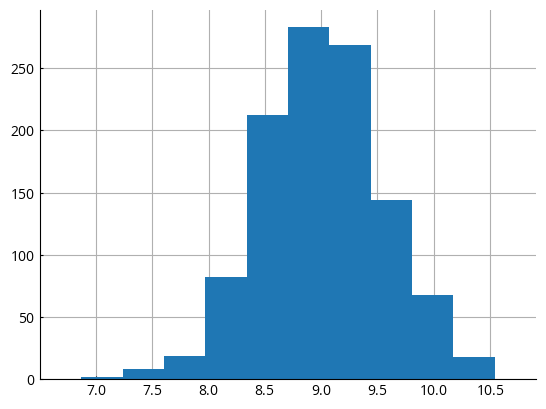

In [ ]:
log_data = np.log(fdf['base_RID'])

print(stats.anderson(log_data))
log_data.hist()

# np.save('data/validation_data/goda_data/log_base_sizes.npy', log_data)

AndersonResult(statistic=np.float64(0.6136988610646767), critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(8.97698620368197), scale=np.float64(0.5843484049542096))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


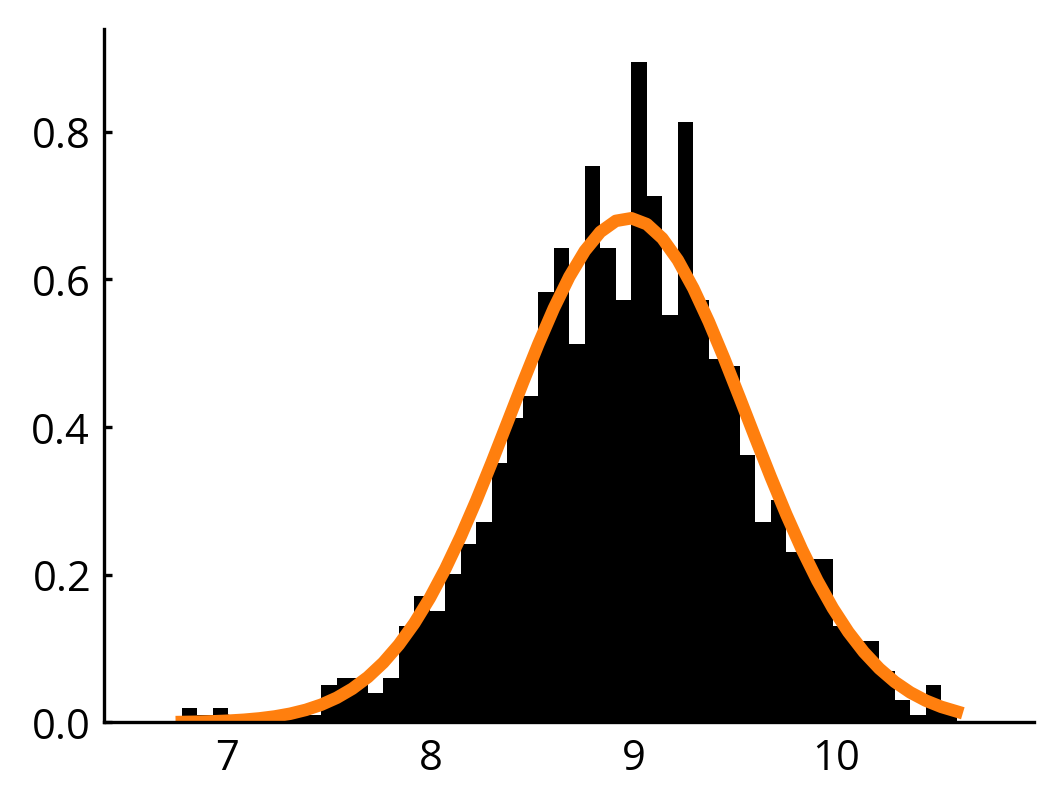

In [40]:
log_y = np.log(df['base_RID'].to_numpy())
dist = stats.norm

fitres = dist.fit(log_y)
print(stats.anderson(log_y))

fig, ax = plt.subplots(1,1,figsize=(4,3), dpi=300)

_, bins, _ = ax.hist(log_y, density=True, bins=50, color='black')
ax.plot(bins, dist.pdf(bins, *fitres), color='tab:orange', linewidth=3)

Text(0, 0.5, 'pdf')

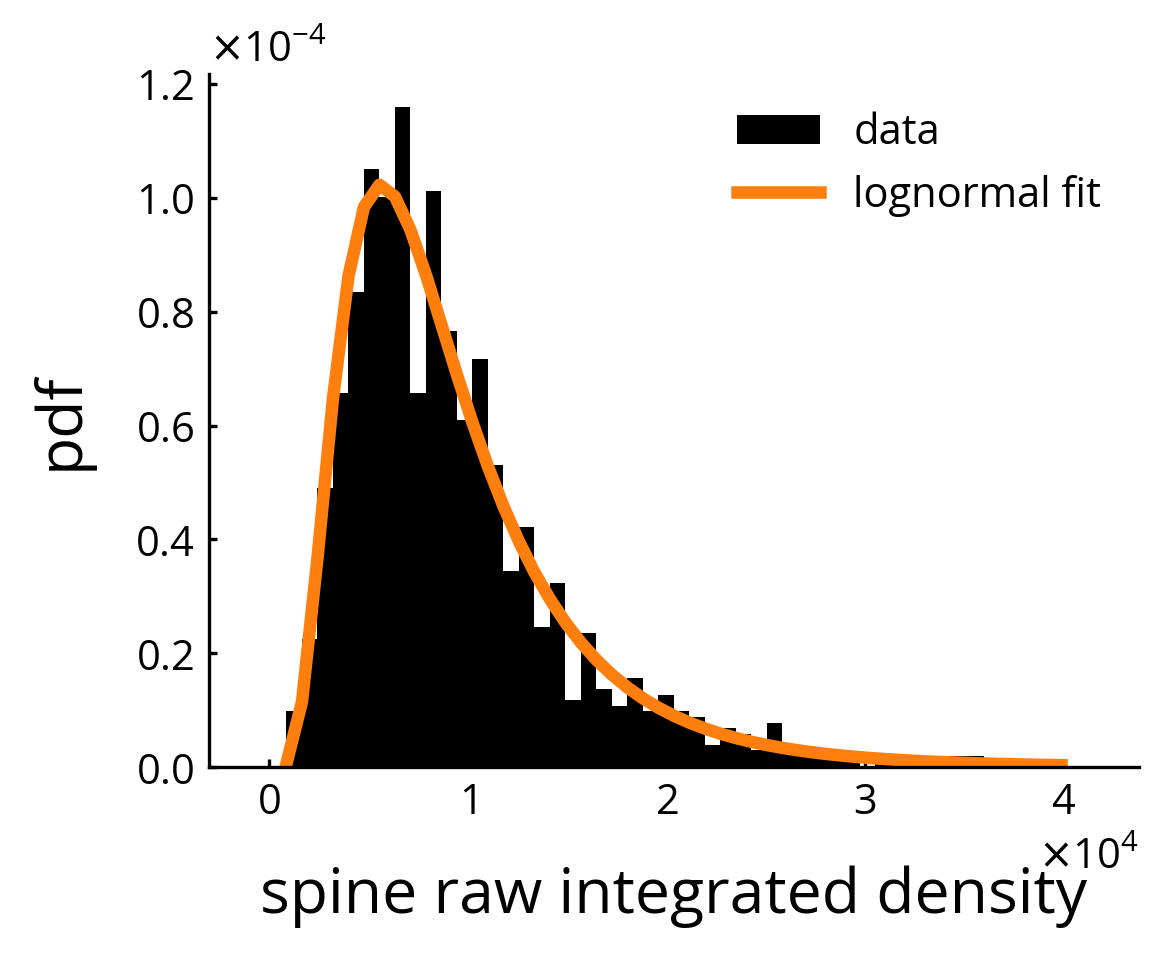

In [41]:
y = np.exp(log_y)
dist = stats.lognorm

fitres = dist.fit(y, floc=0)

fig, ax = plt.subplots(1,1,figsize=(4,3), dpi=300)

_, bins, _ = ax.hist(y, density=True, bins=50, color='black', label='data')
ax.plot(bins, dist.pdf(bins, *fitres), color='tab:orange', linewidth=3, label='lognormal fit')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[0,1], useMathText=True)

ax.legend(frameon=False)
ax.set_xlabel('spine raw integrated density')
ax.set_ylabel('pdf')